# Trabajo Practico Integrador parte 1- An√°lisis de Datos

**Grupo:** Mariano Campos, Leandro Lepera, Ojeda Juan Cruz  
**Cohorte:** 19Co2024 - CEIA  
**Materia:** An√°lisis de Datos  
**Tema asignado:** Meteorolog√≠a en Argentina


## 1. Motivaci√≥n

Para este trabajo final, se nos asign√≥ el dataset relacionado con la **meteorolog√≠a en Argentina**, con el objetivo de aplicar herramientas de an√°lisis de datos para comprender mejor fen√≥menos climatol√≥gicos recientes y su comparaci√≥n con patrones hist√≥ricos.

Contamos con dos fuentes de informaci√≥n:
- Un registro **diario** de temperaturas del **√∫ltimo a√±o**.
- Estad√≠sticas **mensuales promedio** de los **√∫ltimos 30 a√±os** (1991‚Äì2020).

## 2. Contexto y descripci√≥n del dataset

Para este trabajo se utilizan conjuntos de datos oficiales del **Servicio Meteorol√≥gico Nacional (SMN)** de Argentina, extra√≠dos de su portal de datos abiertos.

### Dataset 1: Registro diario de temperaturas (√∫ltimo a√±o)

- **Fuente:** Datos abiertos del SMN.
- **Contenido:** Registros **diarios** de temperaturas m√≠nimas y m√°ximas correspondientes a m√∫ltiples estaciones meteorol√≥gicas distribuidas en el pa√≠s.
- **Variables principales:** Fecha, nombre de la estaci√≥n, provincia, temperatura m√≠nima, temperatura m√°xima.
- **Periodo:** √öltimos 365 d√≠as (a partir de la fecha de descarga).
- **Formato original:** Texto plano delimitado por tabulaciones (`.txt`), una fila por d√≠a por estaci√≥n.

### Dataset 2: Estad√≠sticas normales (promedios 1991‚Äì2020)

- **Fuente:** Datos abiertos del SMN.
- **Contenido:** Promedios **mensuales** de variables meteorol√≥gicas calculados sobre un periodo de 30 a√±os (1991 a 2020), utilizados como referencia clim√°tica.
- **Variables principales:** Estaci√≥n, variable medida (ej. temperatura m√≠nima, temperatura m√°xima), y valores mensuales de enero a diciembre.
- **Periodo:** Promedios 1991‚Äì2020.
- **Formato original:** Texto plano delimitado por tabulaciones (`.txt`), una fila por estaci√≥n y por variable.

### Dataset 3: Ubicaci√≥n geogr√°fica de estaciones meteorol√≥gicas

- **Fuente:** Datos abiertos del SMN.
- **Contenido:** Informaci√≥n geogr√°fica de las estaciones meteorol√≥gicas utilizadas en los otros dos datasets.
- **Variables principales:** Nombre de estaci√≥n, provincia, latitud, longitud, altitud, c√≥digo OACI.
- **Uso en este trabajo:** Se utiliz√≥ para incorporar coordenadas geogr√°ficas a las estaciones, lo que permiti√≥ realizar an√°lisis regionales y visualizaciones espaciales.
- **Archivo:** `estaciones_smn.txt`

### Consideraciones

Todos los archivos fueron verificados con los docentes como los correspondientes al tema asignado. Durante el an√°lisis, se realizaron transformaciones para adecuar los formatos (por ejemplo, convertir el segundo dataset a formato largo) y unificar criterios para permitir la comparaci√≥n entre las fuentes. Adem√°s, el uso del tercer dataset permiti√≥ agrupar estaciones por regi√≥n geogr√°fica y enriquecer el an√°lisis clim√°tico.


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
#from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import json

## 2.1 Exploraci√≥n y comprensi√≥n de los datos

En esta secci√≥n se describe la estructura general de los datasets, visualizando las primeras filas, tipos de datos y cantidad de registros. Tambi√©n se realiza una primera evaluaci√≥n de valores faltantes y posibles inconsistencias.

---

### Dataset: registro_temperatura365d_smn

In [12]:
df_ly_raw = pd.read_fwf("Datos/registro_temperatura365d_smn.txt", skiprows=1, encoding="latin1") #La primera linea esta en blanco (skiprows=1)
print(f"Cantidad de filas: {df_ly_raw.shape[0]}")
print(f"Cantidad de columnas: {df_ly_raw.shape[1]}")

df_ly_raw.head()

Cantidad de filas: 42916
Cantidad de columnas: 4


FECHA   TMAX   TMIN                                    NOMBRE
0  --------  -----  -----  ----------------------------------------
1  30032025   28.9   21.4                           AEROPARQUE AERO
2  30032025   23.0   13.7                                 AZUL AERO
3  30032025   22.6   14.6                         BAHIA BLANCA AERO
4  30032025   12.6    4.4                            BARILOCHE AERO

In [13]:
print('Nombres y tipos de columnas')
df_ly_raw.dtypes

Nombres y tipos de columnas


FECHA     object
TMAX      object
TMIN      object
NOMBRE    object
dtype: object

In [14]:
print('Cantidad de valores nulos por columna')
df_ly_raw.isnull().sum()

Cantidad de valores nulos por columna


FECHA        0
TMAX      4525
TMIN       620
NOMBRE       0
dtype: int64

Visualizando los valores nulos


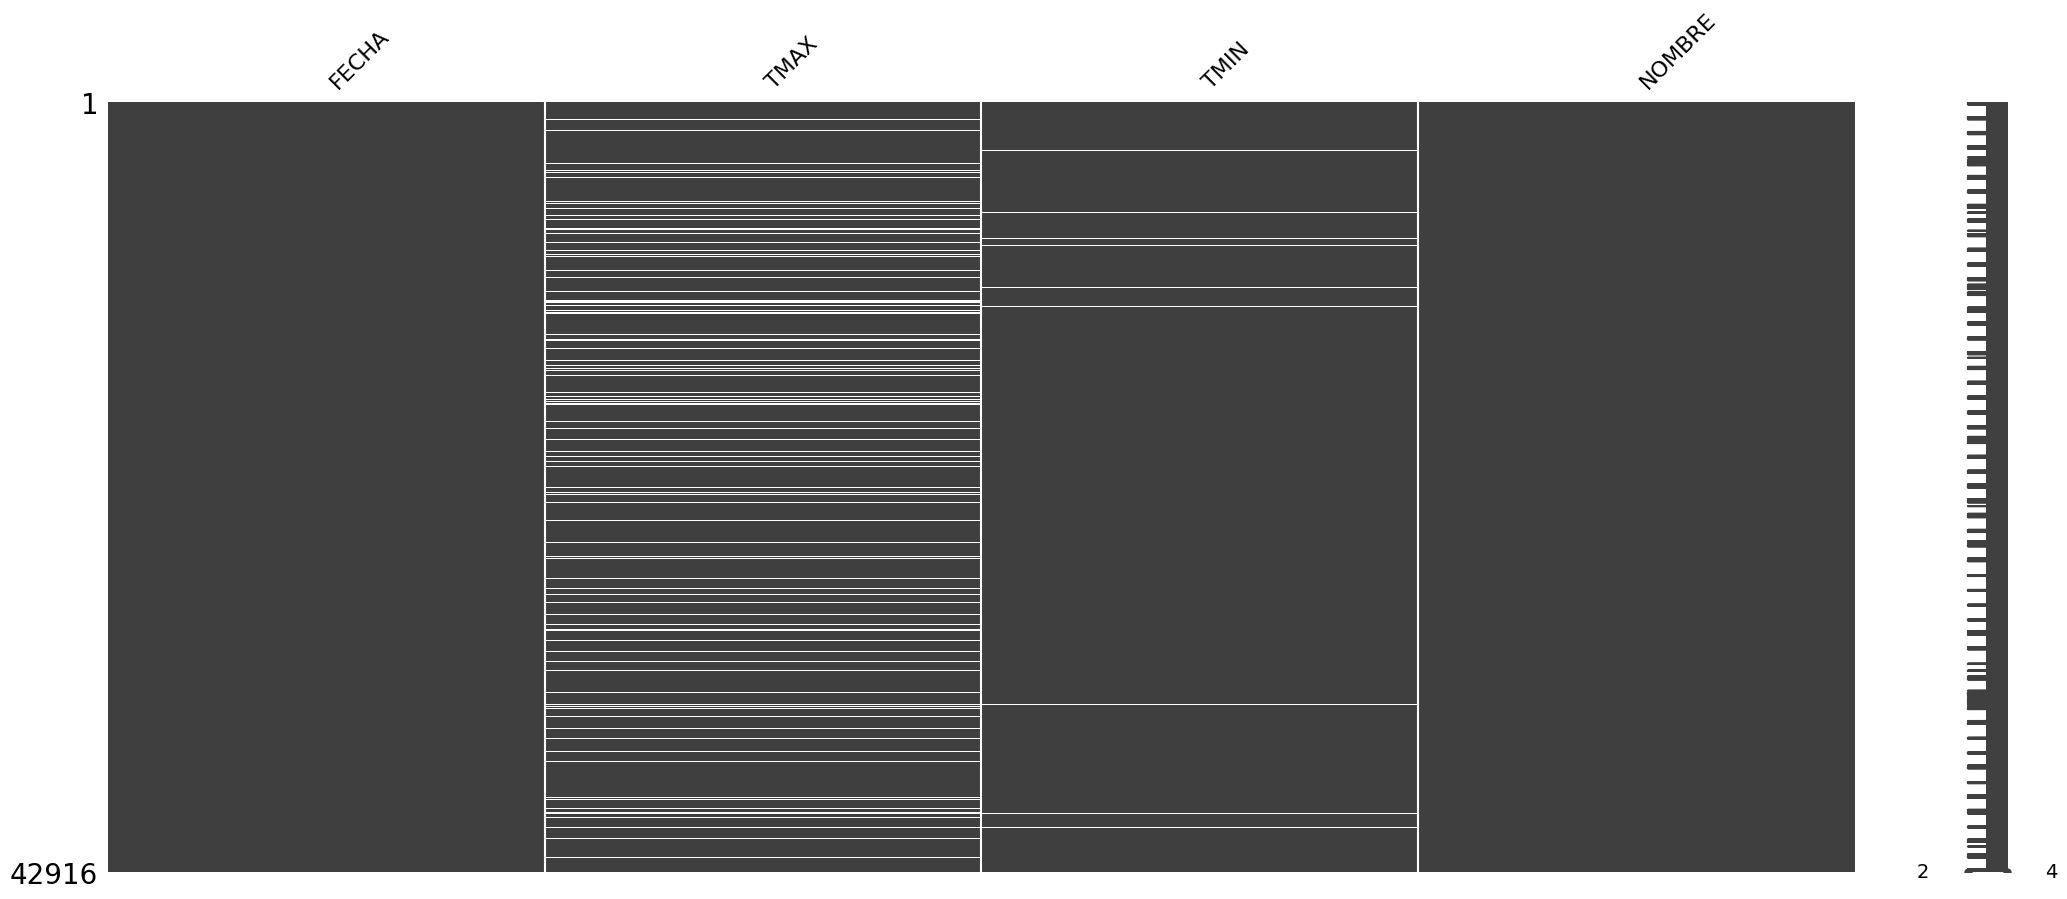

In [15]:
print('Visualizando los valores nulos')
msno.matrix(df_ly_raw);

In [16]:
print("Estaciones √∫nicas:")
print(df_ly_raw['NOMBRE'].nunique())

Estaciones √∫nicas:
119


A partir de la inspecci√≥n inicial del dataset `df_ly_raw`, se observa lo siguiente:

- El dataset contiene una gran cantidad de filas (una por estaci√≥n por d√≠a) y m√∫ltiples columnas, incluyendo fecha, temperaturas m√≠nimas y m√°ximas y nombre de la estaci√≥n.
- Los nombres de columnas est√°n en may√∫sculas y el separador es por ancho fijo, ya que el archivo fue cargado con `read_fwf`.
- La columna `NOMBRE` representa la estaci√≥n meteorol√≥gica, y hay m√∫ltiples estaciones distintas distribuidas en el pa√≠s, con un total de 119.
- No hay una columna espec√≠fica de provincia o ubicaci√≥n geogr√°fica, lo cual podr√≠a requerir un enriquecimiento posterior si se desea analizar por regi√≥n.
- Algunas columnas tienen valores faltantes, especialmente en `TMAX` y `TMIN`, que se analizar√°n en profundidad en la etapa de limpieza.
- Las fechas est√°n en formato de texto en esta etapa, y se convertir√°n en tipo fecha (`datetime`) m√°s adelante.

Esta exploraci√≥n inicial permite comprender la estructura general del dataset, detectar posibles inconsistencias, y planificar las transformaciones necesarias para el an√°lisis.

---

### Dataset: Estad√≠sticas normales Datos abiertos 1991-2020

In [19]:
df_30_raw = pd.read_csv("Datos/Estad√≠sticas normales Datos abiertos 1991-2020.txt", sep="\t", skiprows=7, encoding="latin1") #skiprows=7 para saltar las 7 primeras filas que no tienen datos.
#df_30_raw = df_30_raw.dropna(axis=1, how="all")
print(f"Cantidad de filas: {df_30_raw.shape[0]}")
print(f"Cantidad de columnas: {df_30_raw.shape[1]}")

df_30_raw.head(15)

Cantidad de filas: 784
Cantidad de columnas: 15


Estaci√≥n                                     Valor Medio de  \
0   LA QUIACA OBSERVATORIO                                   Temperatura (¬∞C)   
1   LA QUIACA OBSERVATORIO                            Temperatura m√°xima (¬∞C)   
2   LA QUIACA OBSERVATORIO                            Temperatura m√≠nima (¬∞C)   
3   LA QUIACA OBSERVATORIO                               Humedad relativa (%)   
4   LA QUIACA OBSERVATORIO            Velocidad del Viento (km/h) (2011-2020)   
5   LA QUIACA OBSERVATORIO                          Nubosidad total (octavos)   
6   LA QUIACA OBSERVATORIO                                 Precipitaci√≥n (mm)   
7   LA QUIACA OBSERVATORIO  Frecuencia de d√≠as con Precipitaci√≥n superior ...   
8               OR√ÅN AERO*                                   Temperatura (¬∞C)   
9               OR√ÅN AERO*                            Temperatura m√°xima (¬∞C)   
10              OR√ÅN AERO*                            Temperatura m√≠nima (¬∞C)   
11              OR√ÅN AERO*                               Humedad relativa (%)   
12              OR√ÅN AERO*            Velocidad del Viento (km/h) (2011-2020)   
13              OR√ÅN AERO*                          Nubosidad total (octavos)   
14              OR√ÅN AERO*                                 Precipitaci√≥n (mm)   

      Ene    Feb    Mar   Abr   May   Jun   Jul   Ago   Sep   Oct   Nov  \
0    13.2   13.0   12.8  11.3   7.3   4.8   4.5   7.0  10.0  12.4  13.4   
1    20.6   20.4   20.6  20.3  17.8  16.3  16.1  18.0  20.0  21.7  22.5   
2     7.7    7.6    6.6   3.1  -2.5  -5.7  -6.2  -4.0  -0.4   3.3   5.5   
3    62.6   63.2   60.3  46.0  32.6  27.4  25.7  26.7  32.1  42.4  48.6   
4     6.5    6.8    6.7   5.5   4.8   5.5   5.9   6.7   7.9   7.9   7.7   
5     4.9    4.7    3.7   2.3   1.6   1.4   1.3   1.3   1.8   2.6   3.1   
6   101.9   67.9   48.1   6.8   1.1   0.0   0.0   1.2   3.9  14.4  22.2   
7    11.5    9.2    6.8   1.4   0.2   0.0   0.0   0.2   0.6   2.3   3.8   
8    26.4   25.4   23.9  21.3  18.1  15.6  14.9  17.6  21.0  24.5  25.5   
9    32.8   31.4   29.4  26.5  23.4  21.6  22.4  26.2  29.4  31.8  32.4   
10   21.6   21.2   20.3  17.9  14.5  11.3   9.6  11.1  14.2  18.4  19.7   
11   76.5   79.3   82.8  84.3  83.6  81.0  73.8  63.3  55.7  61.1  66.7   
12    S/D    S/D    S/D   S/D   S/D   S/D   S/D   S/D   S/D   S/D   S/D   
13    5.2    5.4    5.7   5.7   5.6   5.0   4.0   3.2   3.7   4.8   5.0   
14  198.4  185.9  157.8  59.5  22.6   7.1   3.0   3.5  16.3  58.9  97.3   

      Dic  Unnamed: 14  
0    13.9          NaN  
1    22.2          NaN  
2     7.3          NaN  
3    55.8          NaN  
4     7.1          NaN  
5     4.1          NaN  
6    63.2          NaN  
7     8.6          NaN  
8    26.4          NaN  
9    33.2          NaN  
10   21.2          NaN  
11   71.5          NaN  
12    S/D          NaN  
13    5.1          NaN  
14  157.3          NaN

In [20]:
print('Nombres y tipos de columnas')
df_30_raw.dtypes

Nombres y tipos de columnas


Estaci√≥n           object
Valor Medio de     object
Ene                object
Feb                object
Mar                object
Abr                object
May                object
Jun                object
Jul                object
Ago                object
Sep                object
Oct                object
Nov                object
Dic                object
Unnamed: 14       float64
dtype: object

In [21]:
print('Cantidad de valores nulos por columna')
df_30_raw.isnull().sum()

Cantidad de valores nulos por columna


Estaci√≥n            0
Valor Medio de      0
Ene                 0
Feb                 0
Mar                 0
Abr                 0
May                 0
Jun                 0
Jul                 0
Ago                 0
Sep                 0
Oct                 0
Nov                 0
Dic                 0
Unnamed: 14       784
dtype: int64

Visualizando los valores nulos


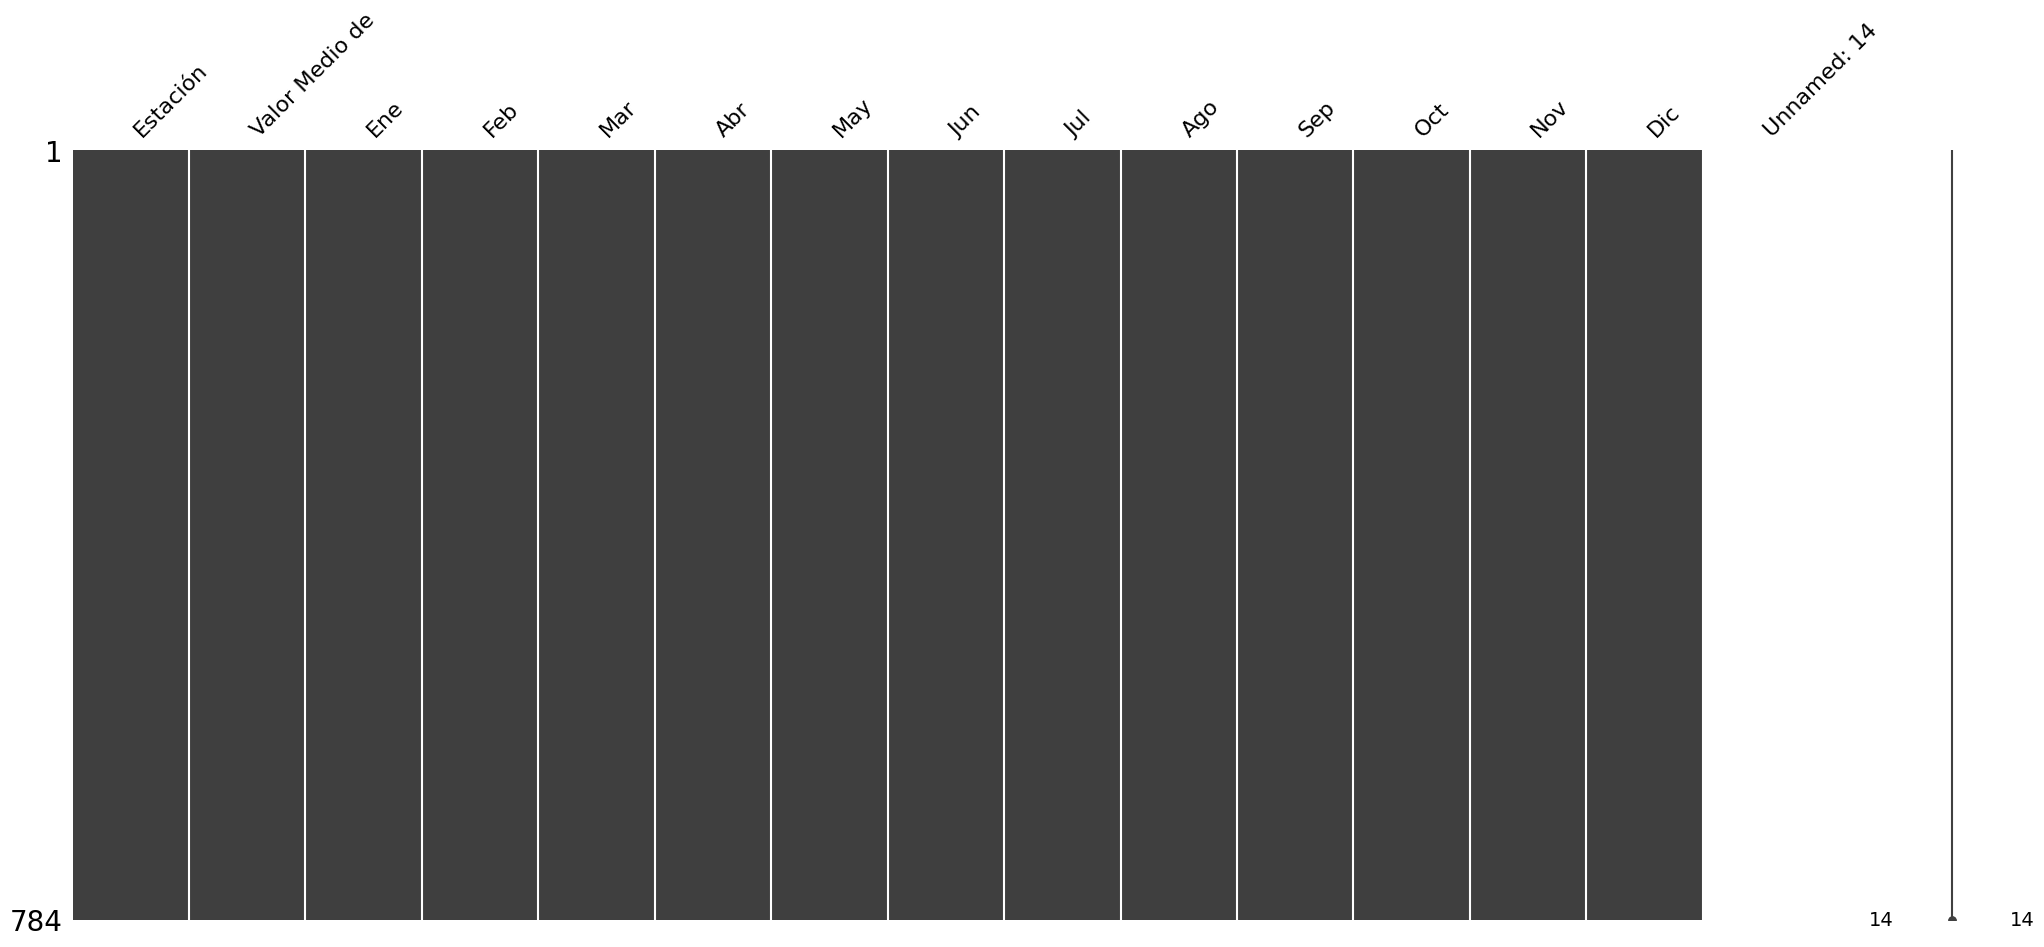

In [22]:
print('Visualizando los valores nulos')
msno.matrix(df_30_raw);

In [23]:
print("Estaciones √∫nicas:")
print(df_30_raw['Estaci√≥n'].nunique())

Estaciones √∫nicas:
98


A partir de la inspecci√≥n inicial del dataset `df_30_raw`, se observa lo siguiente:

- El dataset contiene estad√≠sticas mensuales hist√≥ricas normalizadas para m√∫ltiples estaciones meteorol√≥gicas, con datos promedio del per√≠odo 1991‚Äì2020.
- Cada estaci√≥n aparece repetida en filas distintas seg√∫n la variable clim√°tica (temperatura, humedad, viento, etc.).
- Las variables est√°n descritas en la columna `Valor Medio de`, y los valores correspondientes aparecen distribuidos en columnas mensuales: `Ene`, `Feb`, ..., `Dic`.
- Hay una columna adicional sin nombre √∫til (`Unnamed: 14`), que ser√° descartada m√°s adelante.
- Las estaciones est√°n identificadas por nombre, pero no se incluye informaci√≥n geogr√°fica adicional (provincia, latitud, etc.).
- Algunas filas incluyen variables agregadas como "Nubosidad total" o "Velocidad del Viento", y puede haber diferencias en la cantidad de a√±os considerados para ciertas variables (por ejemplo, viento: 2011‚Äì2020).
- **Si bien a primera vista no se detectan valores faltantes (`NaN`) al ejecutar `isnull().sum()`, al observar los datos crudos y la matriz de datos faltantes se detecta que existen celdas con el texto `'S/D'` (Sin Dato), lo cual implica que estos valores est√°n presentes pero no como `NaN`. Esto ser√° tratado en la etapa de limpieza.**

Esta exploraci√≥n inicial permite tener una idea general de la estructura y contenido del dataset antes de aplicar transformaciones para su an√°lisis.



## 2.2 Aplicaci√≥n de t√©cnicas de visualizaci√≥n

Se aplican herramientas gr√°ficas como histogramas, boxplots, l√≠neas de tiempo y otros para explorar el comportamiento de las variables principales y detectar patrones, estacionalidades o valores at√≠picos.

---

### Dataset: registro_temperatura365d_smn

In [24]:
df_ly = df_ly_raw.copy() # Copia del dataframe original

# Quitar filas que no tengan una fecha v√°lida (por ejemplo, si tienen guiones)
df_ly = df_ly[df_ly['FECHA'].str.fullmatch(r"\d{8}")] # Filtrar fechas con formato de 8 d√≠gitos (d√≠a-mes-a√±o) 

df_ly['FECHA'] = pd.to_datetime(df_ly['FECHA'], format = '%d%m%Y') # Convertir a fecha con formato d√≠a-mes-a√±o
df_ly['TMAX'] = pd.to_numeric(df_ly['TMAX'], errors='coerce') # Ignorar errores de conversi√≥n a num√©rico (por ejemplo, guiones)
df_ly['TMIN'] = pd.to_numeric(df_ly['TMIN'], errors='coerce') # Ignorar errores de conversi√≥n a num√©rico (por ejemplo, guiones)
df_ly['NOMBRE'] = df_ly['NOMBRE'].astype('category') # Convertir a categor√≠a

In [26]:
### Exportaci√≥n para leer en otra Notebook

# Detectar columnas categ√≥ricas
categorical_cols = [col for col, dtype in df_ly.dtypes.items() if str(dtype) == 'category']

# Guardar los tipos como strings
dtypes_str = {col: str(dtype) for col, dtype in df_ly.dtypes.items()}

# Guardar todo en un solo JSON
info = {
    "dtypes": dtypes_str,
    "categoricals": categorical_cols
}

with open("Datos/df_ly_dtypes.json", "w") as f:
    json.dump(info, f)

# exportar CSV
df_ly.to_csv('Datos/df_ly.csv', index=False)


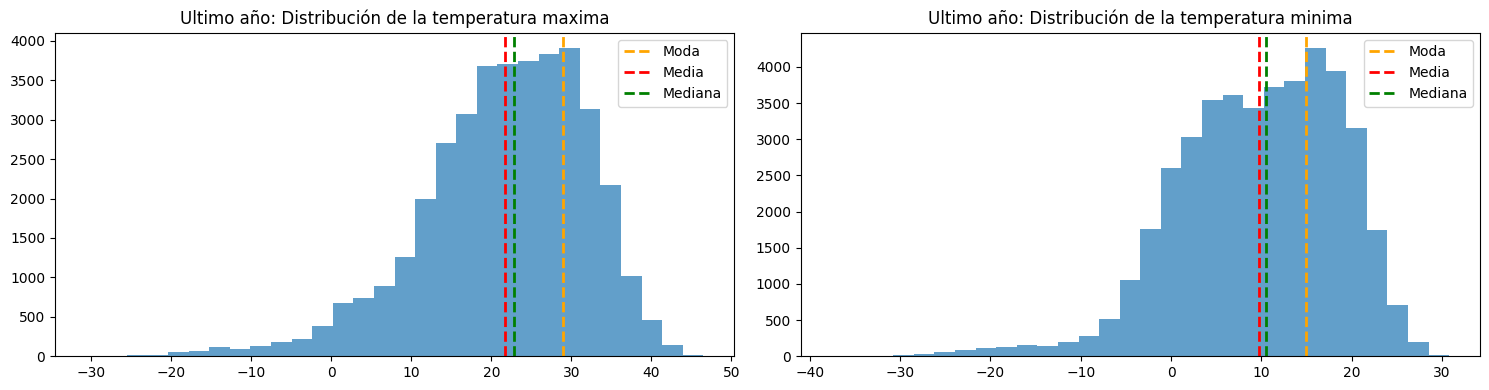

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

# Funci√≥n para graficar
def plot_distribution(ax, data, title):
    ax.hist(data, bins=30, alpha=0.7) # dibujar histograma
    ax.axvline(data.mode()[0], color='orange', linestyle='dashed', linewidth=2, label='Moda') # dibujar la moda
    ax.axvline(data.mean(), color='red', linestyle='dashed', linewidth=2, label='Media') # dibujar la media
    ax.axvline(data.median(), color='green', linestyle='dashed', linewidth=2, label='Mediana') # dibujar la mediana
    ax.set_title(title)
    ax.legend()

plot_distribution(axes[0], df_ly['TMAX'], 'Ultimo a√±o: Distribuci√≥n de la temperatura maxima')
plot_distribution(axes[1], df_ly['TMIN'], 'Ultimo a√±o: Distribuci√≥n de la temperatura minima')

plt.tight_layout()
plt.show()

Se observan las distribuciones de temperaturas m√°ximas y m√≠nimas durante el √∫ltimo a√±o. Las l√≠neas verticales indican la moda (naranja), media (roja) y mediana (verde), lo que permite detectar asimetr√≠as y valores t√≠picos. La distribuci√≥n es esperablemente amplia, dada la diversidad clim√°tica del pa√≠s.

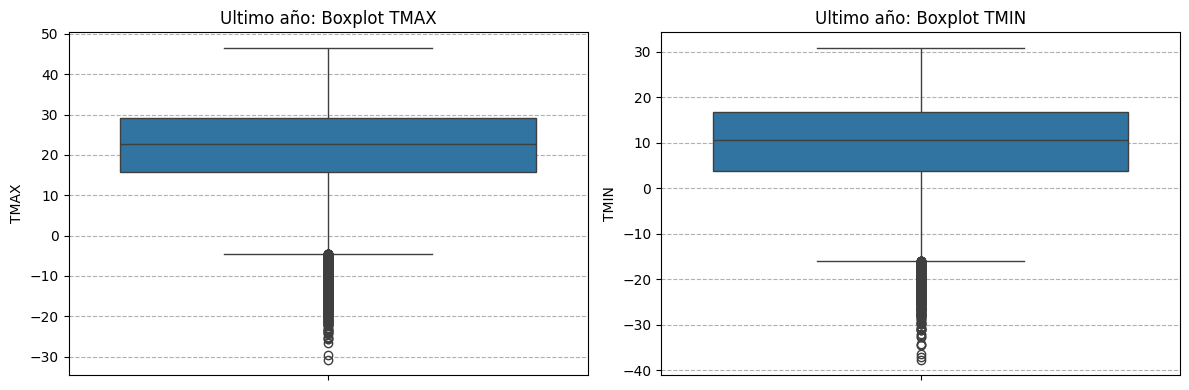

In [16]:
fig, ax = plt.subplots(1,2, figsize=(12, 4))

# ejemplo:
sns.boxplot(data=df_ly, y='TMAX', ax=ax[0])
sns.boxplot(data=df_ly, y='TMIN', ax=ax[1])

ax[0].grid(axis='y', ls='--')
ax[1].grid(axis='y', ls='--')
ax[0].set_title('Ultimo a√±o: Boxplot TMAX')
ax[1].set_title('Ultimo a√±o: Boxplot TMIN')

plt.tight_layout()
plt.show()

Los boxplots muestran la dispersi√≥n y los outliers en las temperaturas extremas. La presencia de valores at√≠picos es esperable debido a la inclusi√≥n de estaciones ubicadas en zonas con climas extremos (como la Base Marambio en la Ant√°rtida). No se eliminar√°n ya que representan fen√≥menos reales.

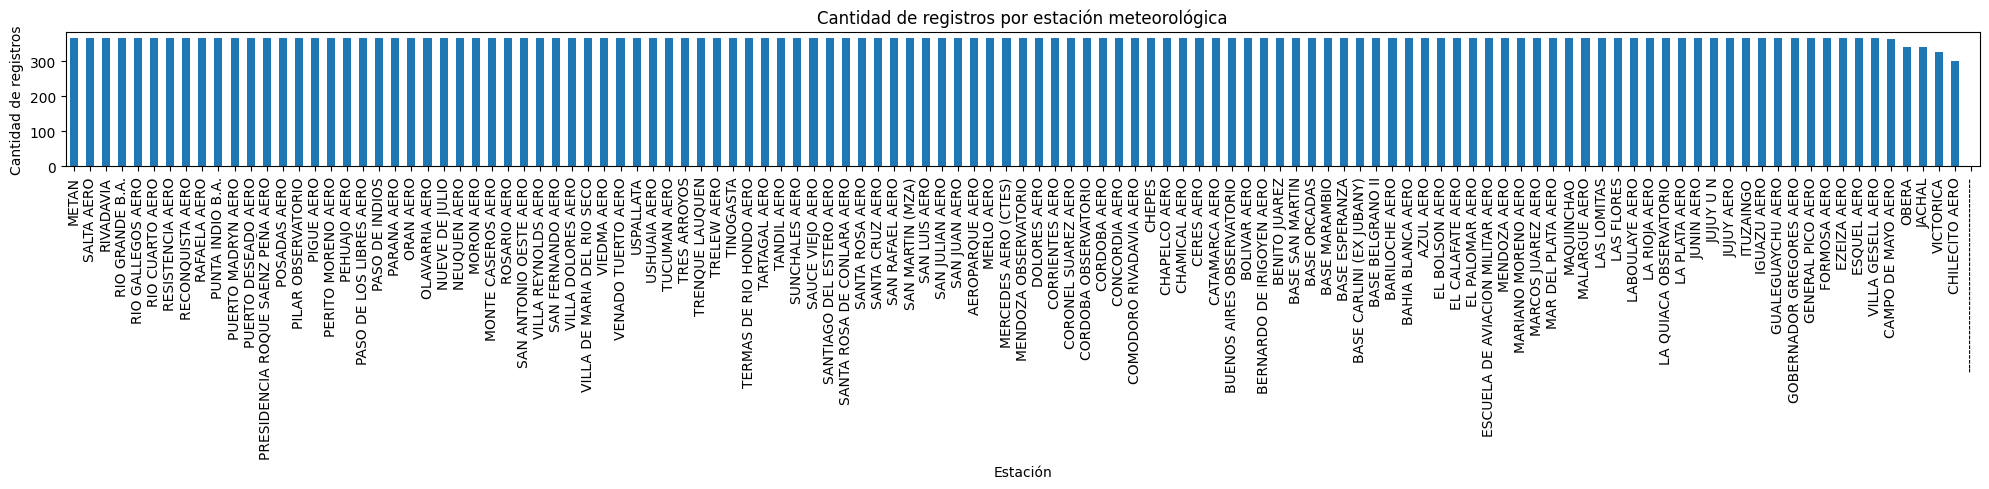

In [17]:
conteo = df_ly_raw['NOMBRE'].value_counts()

plt.figure(figsize=(20,5))
conteo.plot(kind='bar')
plt.title('Cantidad de registros por estaci√≥n meteorol√≥gica')
plt.xlabel('Estaci√≥n')
plt.ylabel('Cantidad de registros')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


Aqu√≠ se muestra cu√°ntos registros tiene cada estaci√≥n meteorol√≥gica en el dataset. Algunas estaciones tienen menos de 365 registros, indicando posibles faltantes de datos o cortes en la recolecci√≥n.

C:\Users\Juan\AppData\Local\Temp\ipykernel_5144\3668180416.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  incompletas = df_ly.groupby('NOMBRE').size()


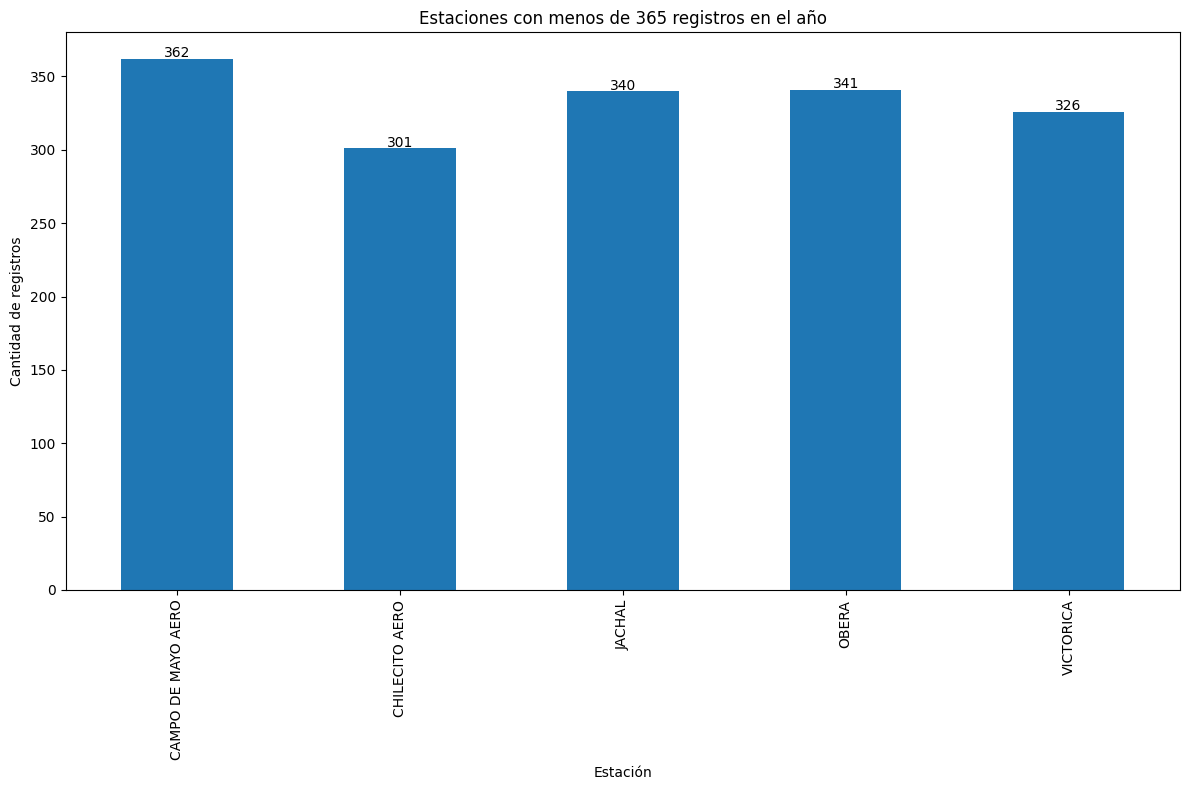

In [18]:
incompletas = df_ly.groupby('NOMBRE').size()
incompletas = incompletas[incompletas < 365]

plt.figure(figsize=(12,8))
ax = incompletas.plot(kind='bar')
plt.title('Estaciones con menos de 365 registros en el a√±o')
plt.xlabel('Estaci√≥n')
plt.ylabel('Cantidad de registros')
plt.xticks(rotation=90)

# Agregar valor encima de cada barra
for i, valor in enumerate(incompletas):
    plt.text(x=i, y=valor + 1, s=str(valor), ha='center', fontsize=10)

plt.tight_layout()
plt.show()


Este gr√°fico enfoca exclusivamente en las estaciones que tienen datos incompletos (menos de 365 d√≠as registrados). Las barras m√°s bajas indican estaciones con mayor cantidad de d√≠as faltantes. Esto permite detectar posibles problemas de cobertura o interrupciones en la recolecci√≥n de datos.

### Dataset: Estad√≠sticas normales Datos abiertos 1991-2020

In [19]:
# Copia y limpieza m√≠nima
df_30 = df_30_raw.copy()
df_30 = df_30.drop(columns=["Unnamed: 14"], errors="ignore")

# Transformar a formato largo
df_30 = df_30.melt(
    id_vars=['Estaci√≥n', 'Valor Medio de'],
    var_name='Mes',
    value_name='Valor'
)

# Convertir tipos
df_30['Estaci√≥n'] = df_30['Estaci√≥n'].astype('category')
df_30['Valor Medio de'] = df_30['Valor Medio de'].astype('category')
df_30['Valor'] = pd.to_numeric(df_30['Valor'], errors='coerce')

# Convertir Mes a categor√≠a ordenada (enero a diciembre)
df_30['Mes'] = pd.Categorical(
    df_30['Mes'],
    categories=['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'],
    ordered=True
)


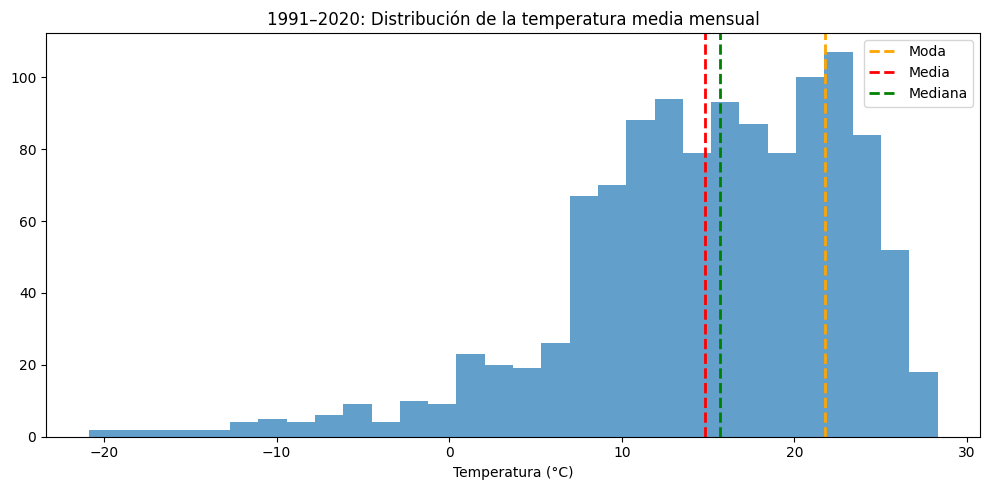

In [20]:
# Filtrar solo filas con temperatura media
df_temp_media = df_30[df_30['Valor Medio de'] == 'Temperatura (¬∞C)'].copy()

# Crear figura y eje
fig, ax = plt.subplots(figsize=(10, 5))

# Dibujar histograma
ax.hist(df_temp_media['Valor'].dropna(), bins=30, alpha=0.7)
ax.axvline(df_temp_media['Valor'].mode()[0], color='orange', linestyle='dashed', linewidth=2, label='Moda')
ax.axvline(df_temp_media['Valor'].mean(), color='red', linestyle='dashed', linewidth=2, label='Media')
ax.axvline(df_temp_media['Valor'].median(), color='green', linestyle='dashed', linewidth=2, label='Mediana')

# Etiquetas y t√≠tulo
ax.set_title('1991‚Äì2020: Distribuci√≥n de la temperatura media mensual')
ax.set_xlabel('Temperatura (¬∞C)')
ax.legend()

plt.tight_layout()
plt.show()

Distribuci√≥n de la temperatura media mensual (1991‚Äì2020)

En este gr√°fico se muestra la distribuci√≥n de las temperaturas medias mensuales, calculadas a partir de los valores hist√≥ricos del per√≠odo 1991‚Äì2020 para todas las estaciones meteorol√≥gicas del pa√≠s.

- La mayor√≠a de los valores se concentran entre los **10‚ÄØ¬∞C y 25‚ÄØ¬∞C**, con una **moda** levemente por encima de los 20‚ÄØ¬∞C.
- Tambi√©n se observan valores negativos, correspondientes a zonas fr√≠as como la Patagonia o regiones de altura.
- Las l√≠neas punteadas indican:
  - **Moda** (naranja): el valor m√°s frecuente.
  - **Media** (roja): promedio de todos los valores.
  - **Mediana** (verde): valor central.
- La distribuci√≥n presenta una leve asimetr√≠a negativa (cola hacia la izquierda), indicando la presencia de registros fr√≠os pero poco frecuentes.

Este an√°lisis ofrece una primera mirada a los rangos t√©rmicos m√°s comunes en Argentina a lo largo de las estaciones del a√±o.


In [21]:
# Calcular el promedio anual por estaci√≥n y variable
df_anual = df_30.groupby(['Estaci√≥n', 'Valor Medio de'], as_index=False)['Valor'].mean()

# Filtrar y renombrar variables clave
variables_interes = [
    'Temperatura (¬∞C)',
    'Humedad relativa (%)',
    'Velocidad del Viento (km/h) (2011-2020)',
    'Precipitaci√≥n (mm)'
]
nombre_vars = {
    'Temperatura (¬∞C)': 'Temperatura media (¬∞C)',
    'Humedad relativa (%)': 'Humedad relativa (%)',
    'Velocidad del Viento (km/h) (2011-2020)': 'Viento (km/h)',
    'Precipitaci√≥n (mm)': 'Precipitaci√≥n (mm)'
}
df_anual = df_anual[df_anual['Valor Medio de'].isin(variables_interes)].copy()
df_anual['Variable'] = df_anual['Valor Medio de'].map(nombre_vars)


C:\Users\Juan\AppData\Local\Temp\ipykernel_5144\3078973787.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_anual = df_30.groupby(['Estaci√≥n', 'Valor Medio de'], as_index=False)['Valor'].mean()


Boxplots del promedio anual (1991‚Äì2020) por estaci√≥n meteorol√≥gica

En los siguientes gr√°ficos se representa la distribuci√≥n del promedio anual para cada variable clim√°tica relevante, considerando los valores medios mensuales de todas las estaciones meteorol√≥gicas del pa√≠s durante el per√≠odo 1991‚Äì2020:

- **Temperatura media (¬∞C):** muestra una dispersi√≥n relativamente baja, con la mayor√≠a de las estaciones en el rango de 10‚ÄØ¬∞C a 20‚ÄØ¬∞C.
- **Humedad relativa (%):** se encuentra mayormente entre el 40‚ÄØ% y el 70‚ÄØ%, con algunas estaciones m√°s secas o m√°s h√∫medas.
- **Velocidad del viento (km/h):** los valores son en general bajos, y se mantiene una distribuci√≥n algo m√°s amplia, aunque moderada.
- **Precipitaci√≥n (mm):** presenta una alta variabilidad, lo cual es esperable dada la diversidad clim√°tica del pa√≠s, desde zonas √°ridas a tropicales.

Estos gr√°ficos permiten identificar r√°pidamente la variabilidad entre estaciones y ayudan a contextualizar los patrones clim√°ticos regionales de Argentina.


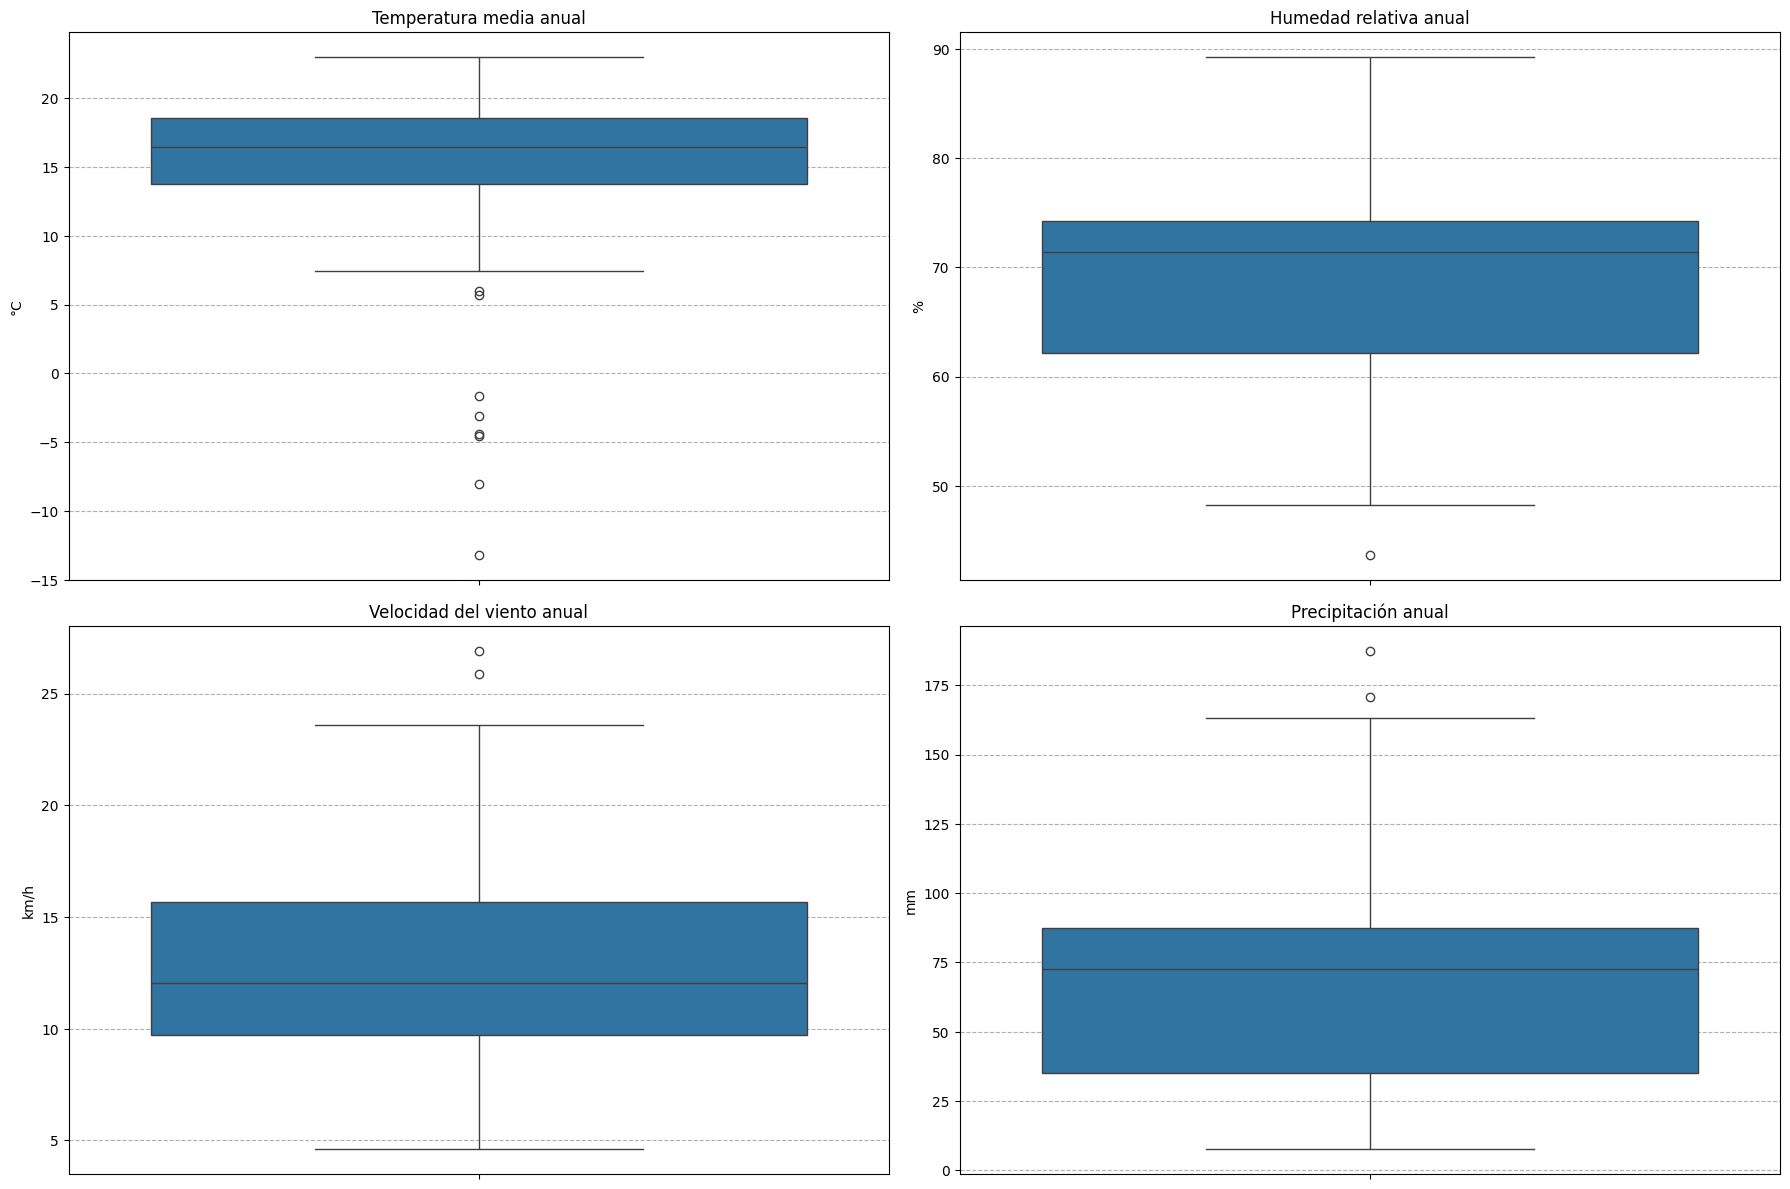

In [22]:
# Crear subplots para cada variable
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Variables y t√≠tulos
variables = [
    ('Temperatura media (¬∞C)', 'Temperatura media anual'),
    ('Humedad relativa (%)', 'Humedad relativa anual'),
    ('Viento (km/h)', 'Velocidad del viento anual'),
    ('Precipitaci√≥n (mm)', 'Precipitaci√≥n anual')
]

# Dibujar los boxplots
for ax, (var, titulo) in zip(axes.flat, variables):
    datos = df_anual[df_anual['Variable'] == var]
    sns.boxplot(data=datos, y='Valor', ax=ax)
    ax.set_title(titulo)
    ax.grid(axis='y', linestyle='--')
    
axes[0,0].set_ylabel('¬∞C')
axes[0,1].set_ylabel('%')
axes[1,0].set_ylabel('km/h')
axes[1,1].set_ylabel('mm')

plt.tight_layout()
plt.show()


Estaciones meteorol√≥gicas con datos faltantes

El siguiente gr√°fico muestra la cantidad total de valores faltantes (`NaN`) por estaci√≥n meteorol√≥gica en el dataset hist√≥rico 1991‚Äì2020. 

Estos valores faltantes provienen originalmente de celdas marcadas como `'S/D'` (Sin Dato) en el archivo crudo, y fueron convertidos expl√≠citamente a `NaN` durante la etapa de formateo.

- Algunas estaciones presentan registros faltantes en m√∫ltiples meses y variables, lo que puede afectar los an√°lisis posteriores.
- Este tipo de visualizaci√≥n permite identificar si los faltantes est√°n concentrados en ciertas estaciones (por ejemplo, remotas o con bajo mantenimiento).
- No se ha realizado todav√≠a ning√∫n proceso de imputaci√≥n o eliminaci√≥n sobre estos datos, pero estas estaciones podr√≠an ser tratadas de forma diferencial m√°s adelante.

Este an√°lisis exploratorio es clave para anticipar decisiones de limpieza y modelado.


C:\Users\Juan\AppData\Local\Temp\ipykernel_5144\1909623450.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  faltantes_por_estacion = df_30[df_30['Valor'].isna()].groupby('Estaci√≥n').size().sort_values(ascending=False)


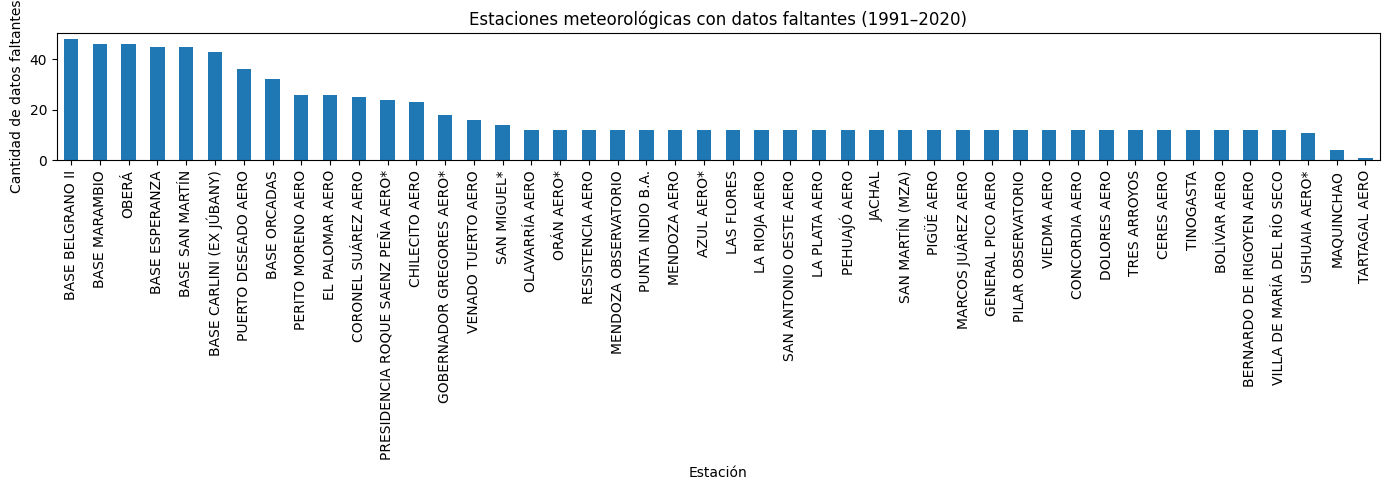

In [23]:
faltantes_por_estacion = df_30[df_30['Valor'].isna()].groupby('Estaci√≥n').size().sort_values(ascending=False)
faltantes_por_estacion = faltantes_por_estacion[faltantes_por_estacion > 0]

plt.figure(figsize=(14, 5))
faltantes_por_estacion.plot(kind='bar')
plt.ylabel('Cantidad de datos faltantes')
plt.title('Estaciones meteorol√≥gicas con datos faltantes (1991‚Äì2020)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


---

En esta secci√≥n se proces√≥ el dataset hist√≥rico del per√≠odo 1991‚Äì2020 (`df_30`), transform√°ndolo al formato largo para facilitar su an√°lisis. Se aplicaron conversiones de tipo, se identificaron datos faltantes y se realizaron m√∫ltiples visualizaciones exploratorias:

- Se cre√≥ un histograma de temperaturas medias mensuales para observar la distribuci√≥n general de los valores en todo el pa√≠s.
- Se construyeron boxplots mensuales por variable clim√°tica (temperatura, humedad, viento y precipitaci√≥n), permitiendo observar estacionalidades y rangos t√≠picos.
- Se analizaron los promedios anuales por estaci√≥n meteorol√≥gica, y se representaron mediante boxplots separados para cada variable.
- Finalmente, se identificaron y graficaron las estaciones con datos faltantes, anticipando la necesidad de tratamientos diferenciales o imputaciones en etapas posteriores.

Esta exploraci√≥n permite comprender tanto la estructura como el comportamiento general del clima en Argentina durante el per√≠odo analizado, y prepara el terreno para etapas de limpieza, enriquecimiento y comparaci√≥n con el √∫ltimo a√±o.


## 2.3 Limpieza del dataset

Aqu√≠ se aplican t√©cnicas para tratar valores nulos, inconsistencias, tipos incorrectos o datos duplicados. Se definen reglas de limpieza y se transforman columnas para facilitar el an√°lisis posterior.

---

### Dataset: registro_temperatura365d_smn

En esta etapa se completan las tareas de limpieza del dataset `df_ly`, que fue creado previamente como copia del original (`df_ly_raw`).

- Se eliminaron filas con fechas inv√°lidas, conservando √∫nicamente aquellas con formato num√©rico de 8 d√≠gitos (DDMMAAAA).
- Se convirtieron las columnas `TMAX` y `TMIN` a tipo num√©rico, generando valores `NaN` en aquellas celdas que conten√≠an guiones u otros valores no interpretables como n√∫meros.
- La columna `FECHA` se transform√≥ a tipo `datetime` para facilitar operaciones temporales.
- Se detectaron valores faltantes (`NaN`) en las columnas de temperatura. Se considera que estos valores son del tipo **MAR (Missing At Random)**, ya que suelen depender de la estaci√≥n meteorol√≥gica y no del valor ausente en s√≠.

Tratamiento de datos faltantes

Como estrategia de imputaci√≥n, se propone rellenar los valores faltantes con la **temperatura promedio mensual de la misma estaci√≥n**, ya que esto respeta la variabilidad estacional y regional de los datos.

La limpieza realizada garantiza que los datos est√©n en formato coherente y listos para la transformaci√≥n y extracci√≥n de nuevas variables.


C:\Users\Juan\AppData\Local\Temp\ipykernel_5144\2911852236.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_ly[col] = df_ly.groupby(['NOMBRE', 'MES'])[col].transform(lambda x: x.fillna(x.mean()))
C:\Users\Juan\AppData\Local\Temp\ipykernel_5144\2911852236.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_ly[col] = df_ly.groupby('NOMBRE')[col].transform(lambda x: x.fillna(x.mean()))


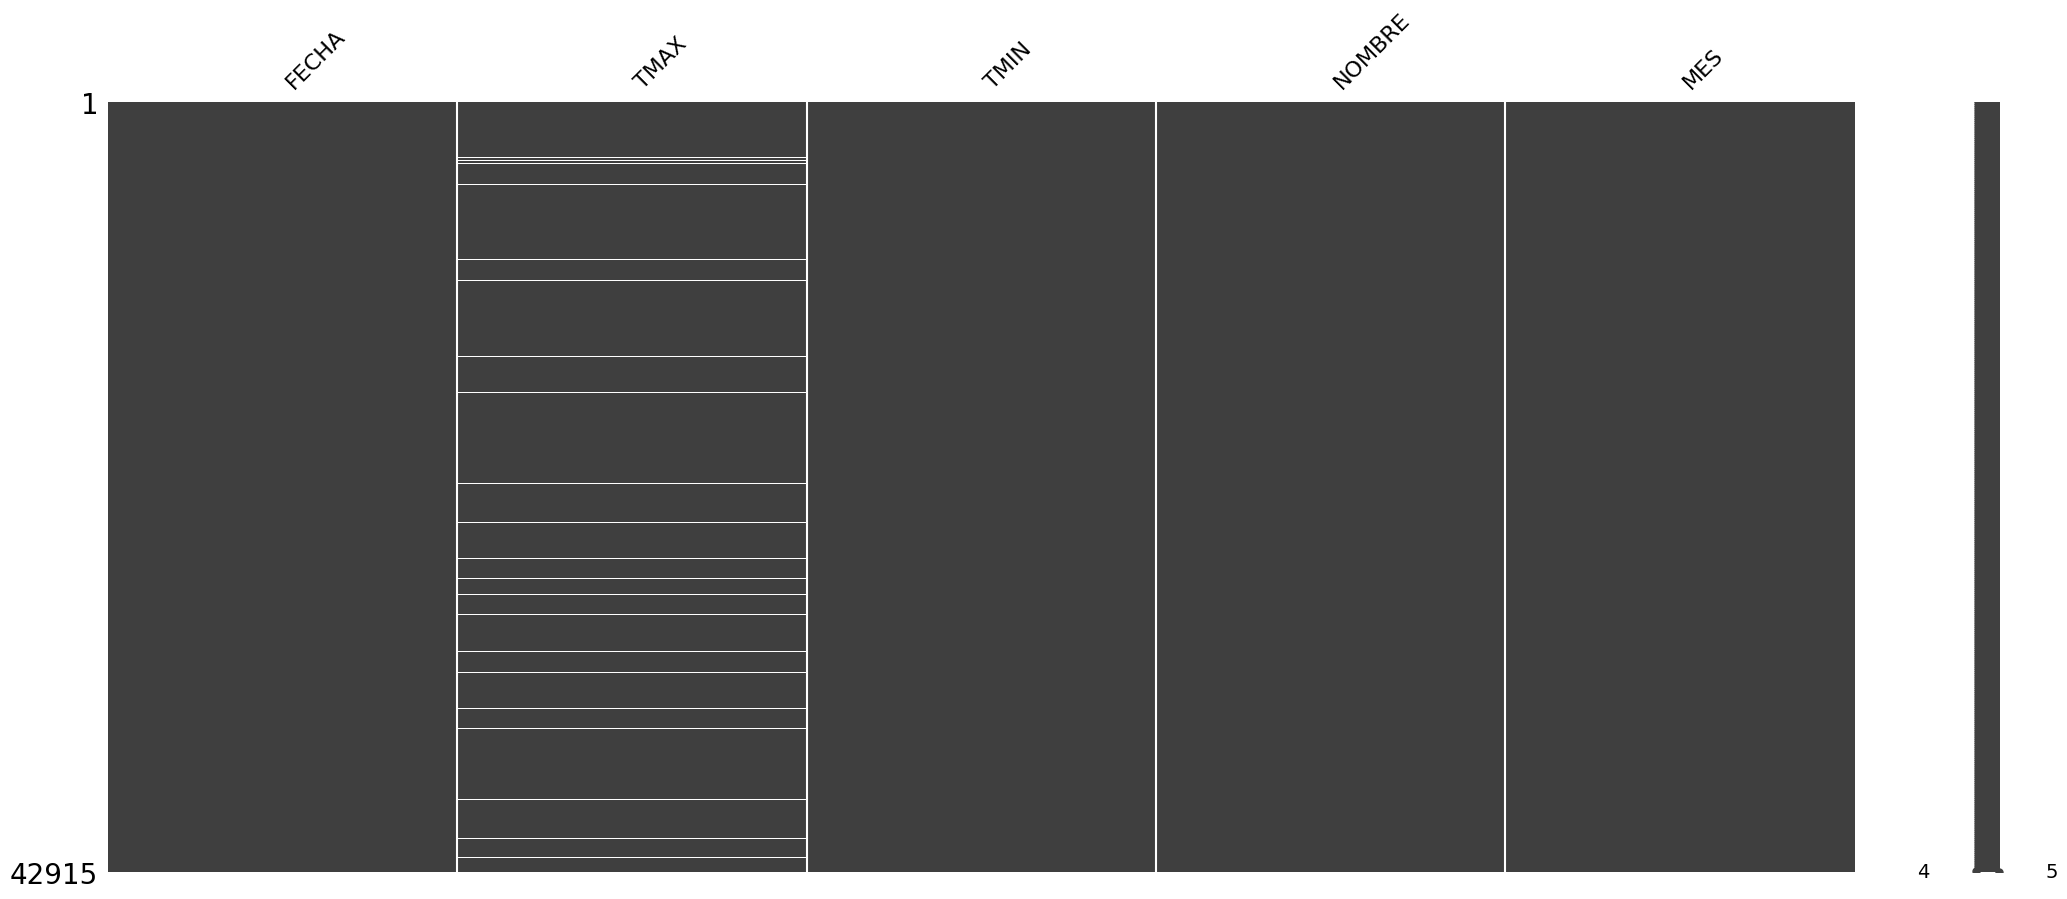

In [24]:
# Agregar columna auxiliar del mes
df_ly['MES'] = df_ly['FECHA'].dt.month

# Imputaci√≥n en dos pasos: mensual por estaci√≥n ‚Üí anual por estaci√≥n
for col in ['TMAX', 'TMIN']:
    # Paso 1: promedio mensual por estaci√≥n
    df_ly[col] = df_ly.groupby(['NOMBRE', 'MES'])[col].transform(lambda x: x.fillna(x.mean()))
    # paso filtrar knn
    # Paso 2: si a√∫n quedan NaNs, usar promedio anual por estaci√≥n
    df_ly[col] = df_ly.groupby('NOMBRE')[col].transform(lambda x: x.fillna(x.mean()))


msno.matrix(df_ly);

#### Clasificaci√≥n del tipo de faltante en TMAX

Inicialmente, se clasificaron como MNAR las observaciones de `TMAX` faltantes en las estaciones "CHAMICAL AERO", "ESCUELA DE AVIACION MILITAR AERO" y "RIO CUARTO AERO", ya que todas las observaciones de esa variable estaban ausentes en dichas estaciones.

Sin embargo, al observar que las temperaturas m√≠nimas (`TMIN`) estaban registradas y que la estaci√≥n, mes y regi√≥n eran conocidos, se reconsider√≥ el tipo de faltante. Se concluy√≥ que `TMAX` podr√≠a imputarse utilizando `TMIN` y la **amplitud t√©rmica promedio** por regi√≥n y mes, por lo tanto, este faltante se ajusta a la categor√≠a **MAR** (Missing At Random).

#### Imputaci√≥n por amplitud t√©rmica regional

Se calcul√≥ la amplitud t√©rmica media (`TMAX - TMIN`) para cada combinaci√≥n de regi√≥n y mes, y luego se imput√≥ `TMAX` como:

TMAX ‚âà TMIN + amplitud_media(REGION, MES)

In [38]:
# Cargar diccionario de regiones actualizado
region_map = pd.read_csv("Datos/estaciones_con_regiones.csv")

# Crear la columna REGION (necesaria para imputaci√≥n por amplitud t√©rmica)
region_dict = dict(zip(region_map["NOMBRE"], region_map["REGION"]))
df_ly["REGION"] = df_ly["NOMBRE"].map(region_dict)



Esta estrategia aprovecha patrones clim√°ticos regionales estables y permite reconstruir los datos sin eliminar estaciones.

La columna `AMP_TERM` fue utilizada exclusivamente como variable auxiliar para imputar valores faltantes en `TMAX` a partir de `TMIN` y la amplitud t√©rmica promedio regional y mensual. Como no ser√° utilizada en los an√°lisis posteriores y presenta una proporci√≥n de valores faltantes, se decidi√≥ eliminarla del dataset final.


In [26]:
print('Cantidad de valores nulos por columna')
df_ly.isnull().sum()

Cantidad de valores nulos por columna


FECHA     0
TMAX      0
TMIN      0
NOMBRE    0
MES       0
REGION    0
dtype: int64

In [27]:
# # Ver qu√© combinaciones de NOMBRE y MES tienen todas las TMAX en NaN
# faltantes_graves = df_ly.groupby(['NOMBRE', 'MES'])['TMAX'].apply(lambda x: x.isna().all())
# faltantes_graves = faltantes_graves.fillna(False)  # ‚Üê esto evita el error
# faltantes_graves[faltantes_graves].index.tolist()

In [28]:
# estaciones_sin_tmax = df_ly.groupby('NOMBRE')['TMAX'].apply(lambda x: x.isna().all())
# estaciones_sin_tmax[estaciones_sin_tmax].index.tolist()


Al analizar los valores faltantes de la variable `TMAX`, se detect√≥ que los m√°s de 1000 valores ausentes se concentran exclusivamente en tres estaciones meteorol√≥gicas:

- CHAMICAL AERO  
- ESCUELA DE AVIACION MILITAR AERO  
- RIO CUARTO AERO

Esto indica que los faltantes no se distribuyen aleatoriamente, ni responden a condiciones estacionales, sino que afectan de forma sistem√°tica a ciertos puntos de medici√≥n. En este contexto, se clasifican como **faltantes del tipo MNAR (Missing Not At Random)**, ya que su aparici√≥n depende de la estaci√≥n y no del valor ausente.

Dado que estas estaciones no cuentan con informaci√≥n suficiente para una imputaci√≥n fiable, se optar√° por excluirlas del an√°lisis posterior para evitar sesgos artificiales en los resultados.


In [29]:
# # Estaciones con todos los TMAX ausentes
# estaciones_excluir = ['CHAMICAL AERO', 'ESCUELA DE AVIACION MILITAR AERO', 'RIO CUARTO AERO']
# df_ly = df_ly[~df_ly['NOMBRE'].isin(estaciones_excluir)]

# msno.matrix(df_ly);

In [37]:
# Leer el JSON
with open("Datos/df_final_actualizado_dtypes.json", "r") as f:
    info = json.load(f)

dtypes_str = info["dtypes"]
categorical_cols = info["categoricals"]

# Detectar columnas especiales
parse_dates = [col for col, dtype in dtypes_str.items() if "datetime" in dtype]
timedeltas = [col for col, dtype in dtypes_str.items() if "timedelta" in dtype]

# Convertir strings de tipo a los tipos correctos
def convertir_dtype(dtype_str):
    if dtype_str.startswith("int"): return "Int64"
    if dtype_str.startswith("float"): return "float"
    if dtype_str == "object": return "string"
    if dtype_str == "bool": return "boolean"
    return "string"

normal_dtypes = {col: convertir_dtype(dtype) for col, dtype in dtypes_str.items()
                 if col not in parse_dates + timedeltas + categorical_cols}


# leer CSV
df_ly = pd.read_csv("Datos/df_final_actualizado.csv", parse_dates=parse_dates, dtype=normal_dtypes)


# Restaurar timedelta
for col in timedeltas:
    df_ly[col] = pd.to_timedelta(df_ly[col])

# Restaurar categoricals
for col in categorical_cols:
    df_ly[col] = df_ly[col].astype("category")


df_ly.head()

FECHA  TMAX  TMIN           NOMBRE  mes        PROVINCIA ALTURA  \
0 2025-01-31  27.7  21.6  AEROPARQUE AERO    1  CAPITAL FEDERAL      6   
1 2025-01-30  27.5  22.8  AEROPARQUE AERO    1  CAPITAL FEDERAL      6   
2 2025-01-29  28.0  21.3  AEROPARQUE AERO    1  CAPITAL FEDERAL      6   
3 2025-01-28  27.5  22.3  AEROPARQUE AERO    1  CAPITAL FEDERAL      6   
4 2025-01-27  28.5  20.3  AEROPARQUE AERO    1  CAPITAL FEDERAL      6   

   LATITUD   LONGITUD  
0   -33.45 -57.583333  
1   -33.45 -57.583333  
2   -33.45 -57.583333  
3   -33.45 -57.583333  
4   -33.45 -57.583333

### Dataset: Estad√≠sticas normales Datos abiertos 1991-2020

En esta secci√≥n se abordan las tareas necesarias para dejar el dataset hist√≥rico (`df_30`) en condiciones √≥ptimas para su an√°lisis comparativo y cruzado con otros conjuntos de datos.

Cabe destacar que parte de la limpieza ya fue realizada durante la etapa de transformaci√≥n en la secci√≥n anterior:

- El dataset fue convertido al formato largo, facilitando su exploraci√≥n por mes, estaci√≥n y variable.
- Se eliminaron columnas vac√≠as (`Unnamed: 14`) y se homogeneizaron los tipos de datos.
- Los valores marcados como `'S/D'` (Sin Dato) en el archivo crudo fueron convertidos expl√≠citamente a `NaN`, lo que permiti√≥ identificar correctamente los datos faltantes.

A continuaci√≥n, se analizar√° la distribuci√≥n de valores nulos por variable y por mes, con el objetivo de decidir posibles estrategias de imputaci√≥n o eliminaci√≥n.

---

An√°lisis de valores faltantes por variable y por mes

En lugar de utilizar una matriz de calor tradicional para visualizar los valores faltantes (t√≠pica en datasets en formato ancho), se opt√≥ por una representaci√≥n alternativa m√°s adecuada al formato largo de este dataset.

El gr√°fico de la izquierda muestra cu√°ntos valores faltantes (`NaN`) hay por cada **variable clim√°tica**. El de la derecha, por su parte, presenta la distribuci√≥n de faltantes a lo largo de los **meses del a√±o**.

Este an√°lisis permite reflexionar sobre la naturaleza de los datos faltantes:

- Algunas variables como el viento o la nubosidad suelen tener m√°s registros faltantes, probablemente por limitaciones en la disponibilidad hist√≥rica o cambios de instrumentos.
- En los meses de invierno o verano pueden concentrarse m√°s faltantes en ciertas estaciones, lo cual podr√≠a relacionarse con condiciones operativas adversas.
- Si los faltantes est√°n distribuidos de manera sistem√°tica, podr√≠a tratarse de un patr√≥n **MAR** (faltantes al azar condicionales). Si adem√°s dependen de la variable misma (por ejemplo, solo falta nubosidad en lugares muy secos), podr√≠an ser incluso **MNAR** (faltantes no al azar).

Este diagn√≥stico orientar√° las decisiones sobre imputaci√≥n, descarte o modelado espec√≠fico de valores ausentes.


C:\Users\Juan\AppData\Local\Temp\ipykernel_5144\326441714.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  faltantes_por_variable = df_30[df_30['Valor'].isna()].groupby('Valor Medio de').size().sort_values(ascending=False)
C:\Users\Juan\AppData\Local\Temp\ipykernel_5144\326441714.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  faltantes_por_mes = df_30[df_30['Valor'].isna()].groupby('Mes').size().reindex(df_30['Mes'].cat.categories)


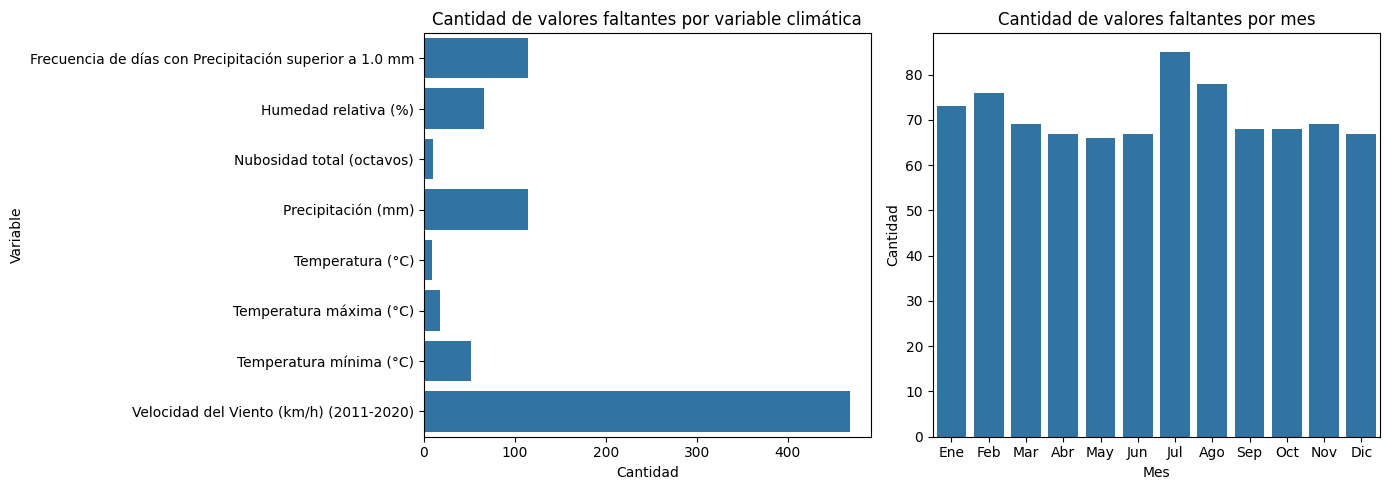

In [30]:
# Contar valores faltantes por variable clim√°tica
faltantes_por_variable = df_30[df_30['Valor'].isna()].groupby('Valor Medio de').size().sort_values(ascending=False)

# Contar valores faltantes por mes
faltantes_por_mes = df_30[df_30['Valor'].isna()].groupby('Mes').size().reindex(df_30['Mes'].cat.categories)

# Crear gr√°ficos
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gr√°fico por variable
sns.barplot(x=faltantes_por_variable.values, y=faltantes_por_variable.index, ax=axes[0])
axes[0].set_title('Cantidad de valores faltantes por variable clim√°tica')
axes[0].set_xlabel('Cantidad')
axes[0].set_ylabel('Variable')

# Gr√°fico por mes
sns.barplot(x=faltantes_por_mes.index, y=faltantes_por_mes.values, ax=axes[1])
axes[1].set_title('Cantidad de valores faltantes por mes')
axes[1].set_xlabel('Mes')
axes[1].set_ylabel('Cantidad')

plt.tight_layout()
plt.show()


<u>Tratamiento de valores faltantes (MAR)</u>

A partir del an√°lisis anterior, se concluye que la mayor√≠a de los valores faltantes en el dataset hist√≥rico pueden clasificarse como **MAR** (faltantes al azar condicionales). Esto significa que su ausencia est√° relacionada con variables observables como:

- El tipo de variable clim√°tica (por ejemplo, viento o nubosidad tienen m√°s faltantes).
- La estaci√≥n meteorol√≥gica (algunas tienen sensores incompletos o se incorporaron m√°s tarde).
- El mes del a√±o (puede haber menos registros en invierno por limitaciones operativas).

Dado que los valores faltantes MAR pueden estimarse razonablemente a partir de otras variables observadas, se considera apropiado aplicar **t√©cnicas de imputaci√≥n** para su tratamiento.
> ‚ö†Ô∏è Nota: Si una estaci√≥n **nunca report√≥ datos** para una variable en todo el per√≠odo, es probable que se trate de un caso **MNAR**, y en ese caso no se recomienda imputar sino tratarlo como un dato estructuralmente ausente.

En la siguiente etapa se aplicar√° una imputaci√≥n controlada, priorizando el uso de promedios agrupados para mantener la coherencia interna del dataset.


## 2.4 Transformaci√≥n de variables y selecci√≥n de features

Se transforman variables seg√∫n sea necesario (por ejemplo, crear una temperatura media entre TMAX y TMIN, extraer mes o estaci√≥n del a√±o desde la fecha, etc.). Tambi√©n se seleccionan las variables m√°s relevantes para el an√°lisis.

---

### Dataset: registro_temperatura365d_smn

> ‚ö†Ô∏è **Nota aclaratoria:**
> 
> La variable `REGION`, aunque conceptualmente forma parte de esta secci√≥n dedicada a la creaci√≥n de nuevas variables, fue incorporada previamente en la secci√≥n 2.3. Esto se debi√≥ a que su existencia era necesaria para realizar una imputaci√≥n fundamentada de valores faltantes en la variable `TMAX`.
> 
> En particular, se utiliz√≥ `REGION` junto con `MES` y `TMIN` para estimar `TMAX` en ciertas estaciones con faltantes totales, utilizando la amplitud t√©rmica promedio regional. Por este motivo, se adelant√≥ su creaci√≥n en el flujo del trabajo, aunque se discute aqu√≠ como transformaci√≥n relevante.


En esta secci√≥n se crean nuevas variables derivadas del dataset original con el objetivo de facilitar el an√°lisis y la construcci√≥n de posibles modelos. Estas transformaciones permiten simplificar el comportamiento de ciertas variables, capturar tendencias temporales y reducir la complejidad del dataset sin perder informaci√≥n relevante.


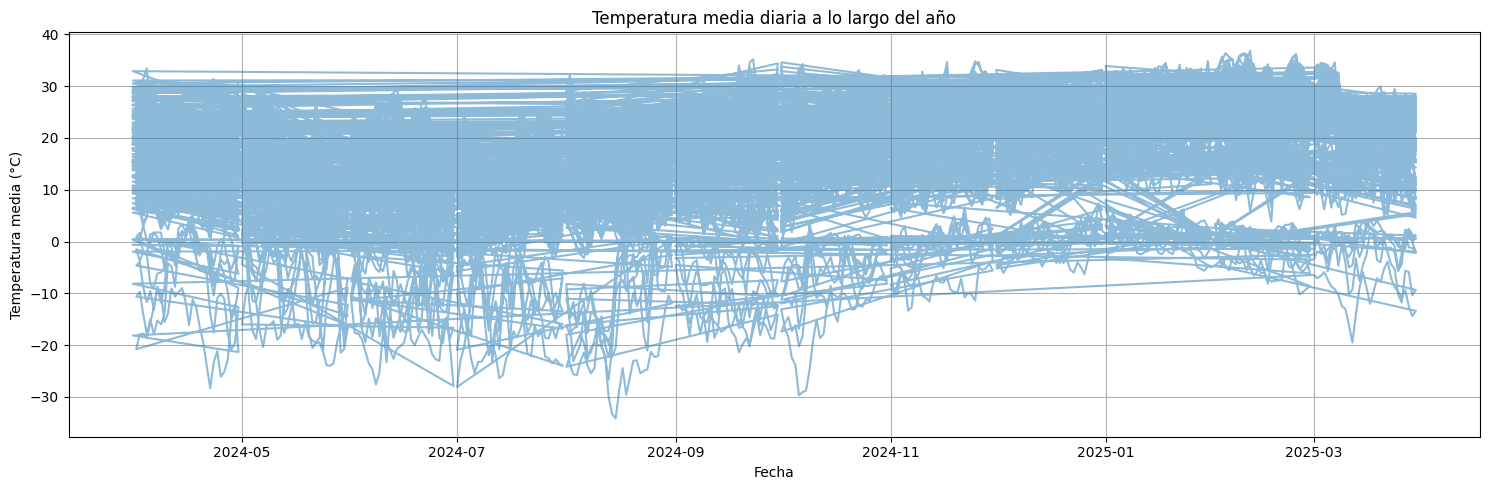

In [39]:
df_ly['TEMP_MEDIA'] = (df_ly['TMAX'] + df_ly['TMIN']) / 2

plt.figure(figsize=(15,5))
plt.plot(df_ly['FECHA'], df_ly['TEMP_MEDIA'], alpha=0.5)
plt.title('Temperatura media diaria a lo largo del a√±o')
plt.xlabel('Fecha')
plt.ylabel('Temperatura media (¬∞C)')
plt.grid(True)
plt.tight_layout()
plt.show()

Este gr√°fico permite observar la evoluci√≥n de la temperatura media diaria a lo largo del a√±o. Se visualiza una estacionalidad clara con m√°ximos en verano y m√≠nimos en invierno, como es caracter√≠stico en el hemisferio sur.

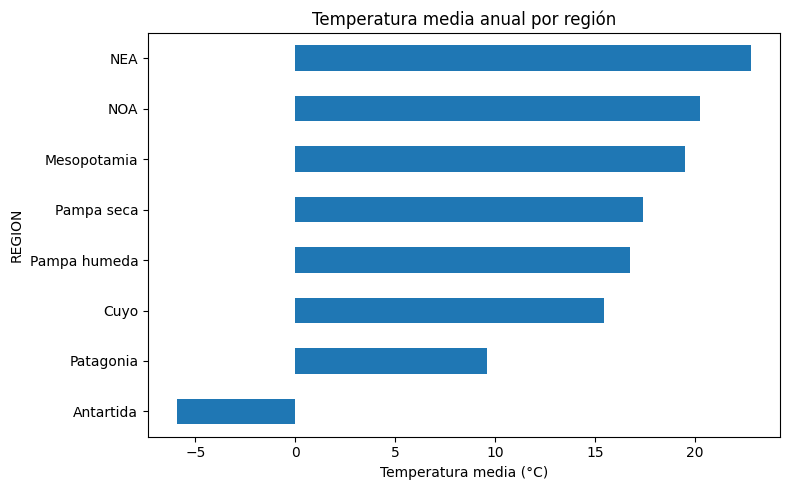

In [40]:
# Agrupar por regi√≥n y calcular media
media_por_region = df_ly.groupby('REGION')['TEMP_MEDIA'].mean().sort_values()

# Gr√°fico de barras horizontales
media_por_region.plot(kind='barh', figsize=(8, 5), title='Temperatura media anual por regi√≥n')
plt.xlabel('Temperatura media (¬∞C)')
plt.tight_layout()
plt.show()


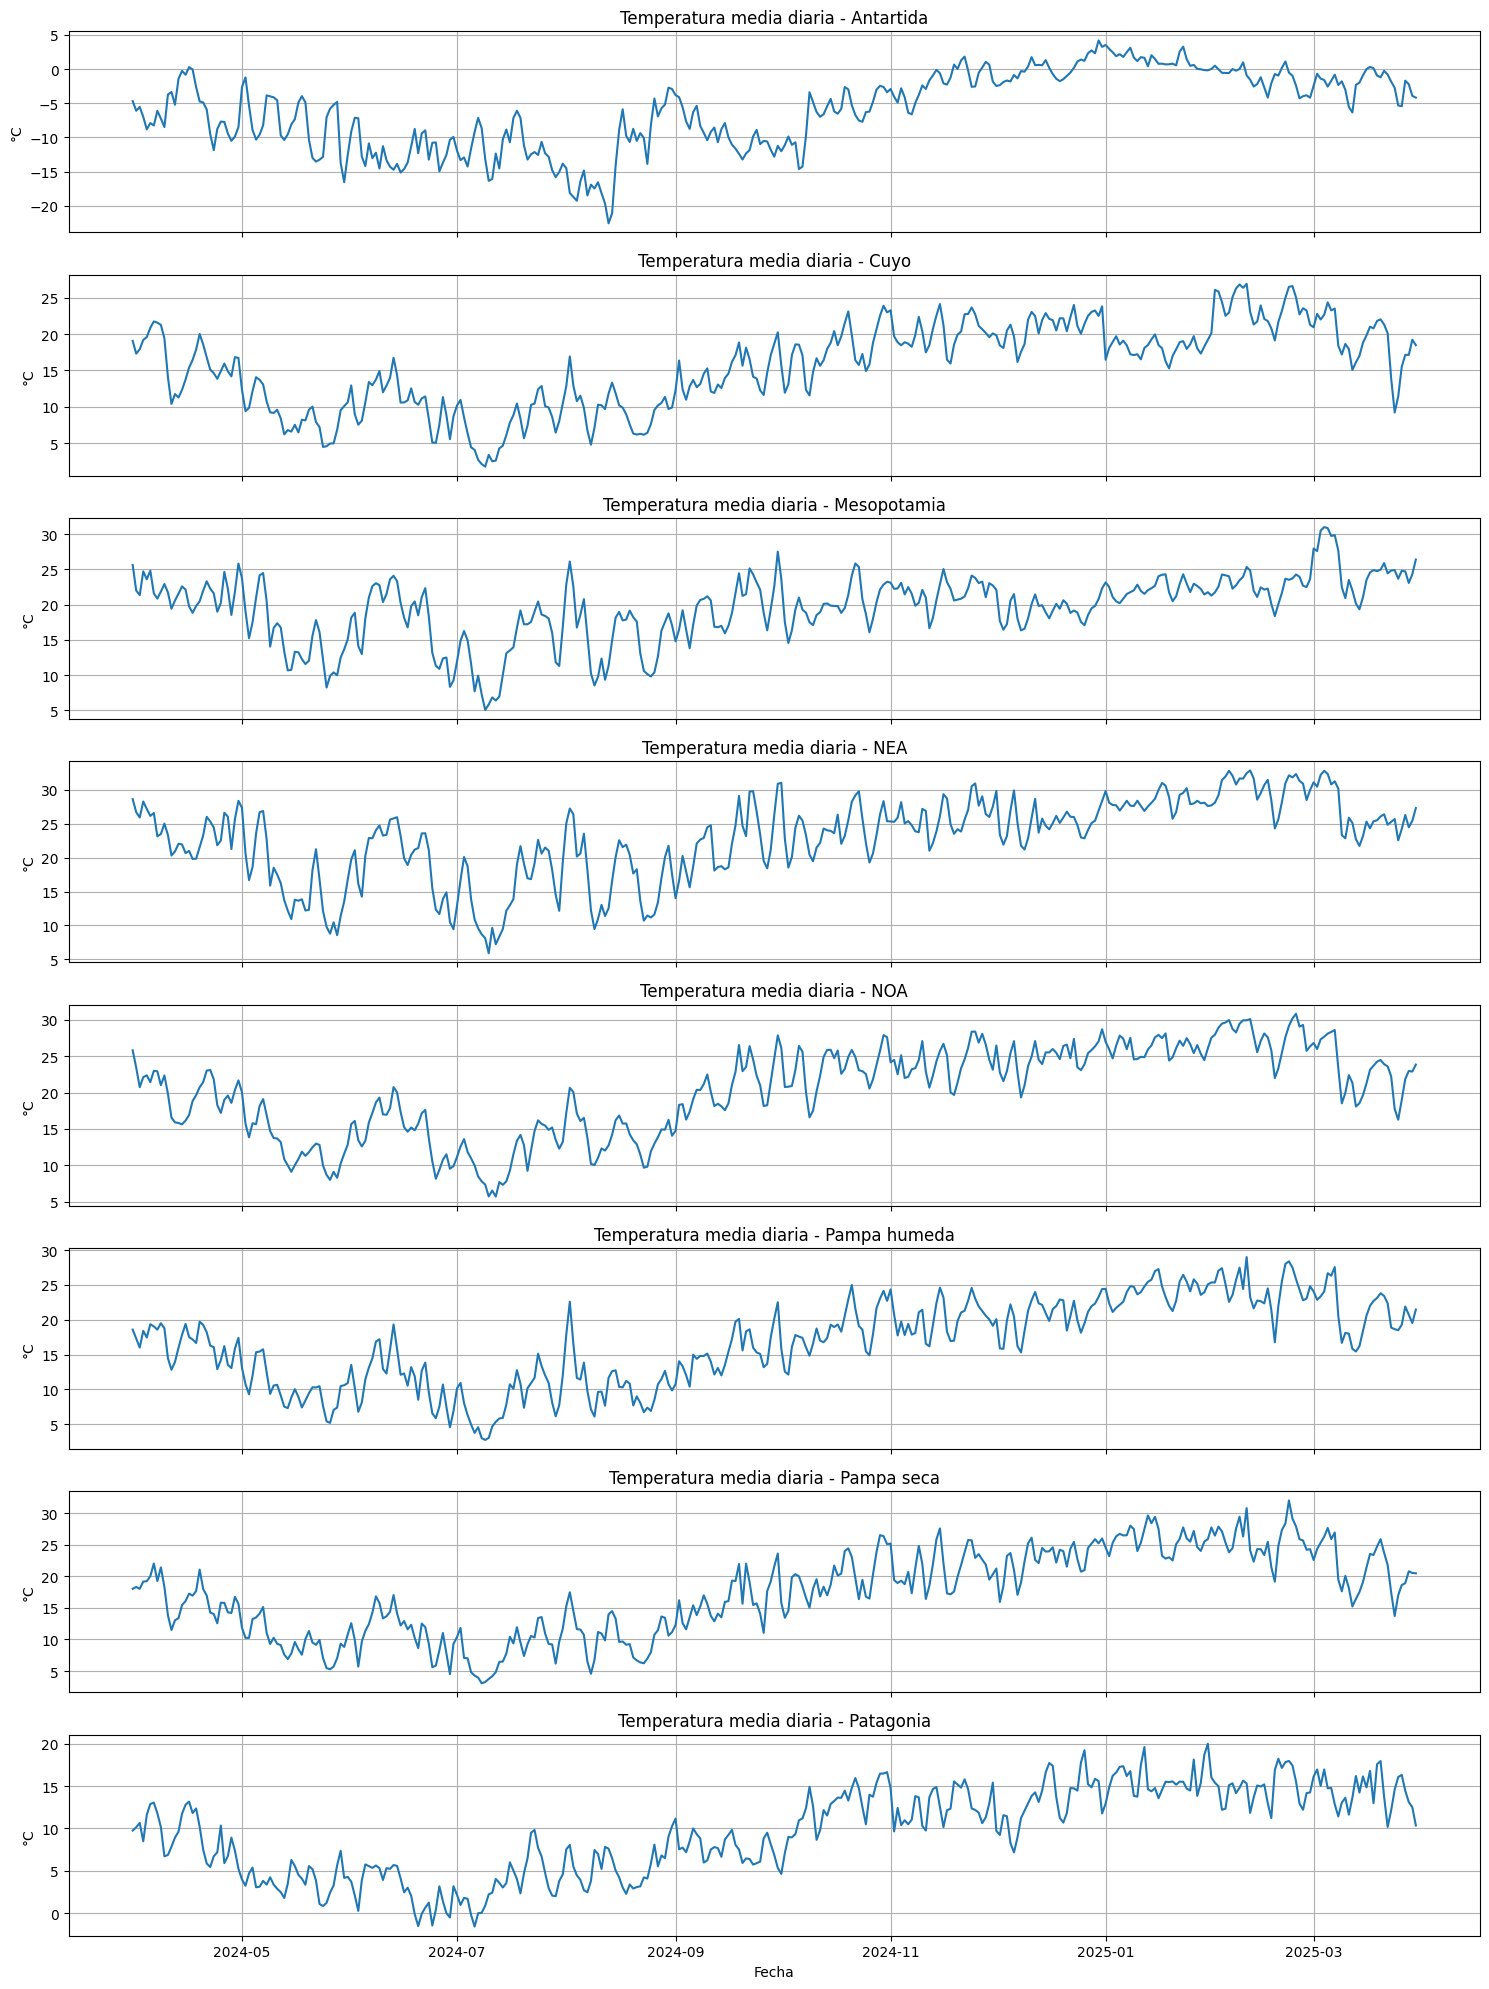

In [41]:
# Ordenamos por fecha por seguridad
df_ly = df_ly.sort_values('FECHA')

# Agrupamos por regi√≥n
regiones = df_ly['REGION'].dropna().unique()
n = len(regiones)

# Creamos los subplots
fig, axes = plt.subplots(n, 1, figsize=(15, 2.5 * n), sharex=True)

for i, region in enumerate(sorted(regiones)):
    ax = axes[i]
    subset = df_ly[df_ly['REGION'] == region]
    media_diaria = subset.groupby('FECHA')['TEMP_MEDIA'].mean()
    ax.plot(media_diaria.index, media_diaria.values, label=region)
    ax.set_title(f"Temperatura media diaria - {region}")
    ax.set_ylabel("¬∞C")
    ax.grid(True)

axes[-1].set_xlabel("Fecha")
plt.tight_layout()
plt.show()


Se calcula la temperatura media anual para cada regi√≥n geogr√°fica. Esto permite observar la variabilidad t√©rmica en el pa√≠s y detectar regiones con climas m√°s extremos o templados.

La regi√≥n m√°s c√°lida del √∫ltimo a√±o fue el noreste argentino y la m√°s fr√≠a fue antartida, lo cual concuerda con las caracter√≠sticas clim√°ticas esperadas.

C:\Users\Juan\AppData\Local\Temp\ipykernel_16164\3610457072.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='REGION', y='TEMP_MEDIA', data=df_ly, palette='Set2')


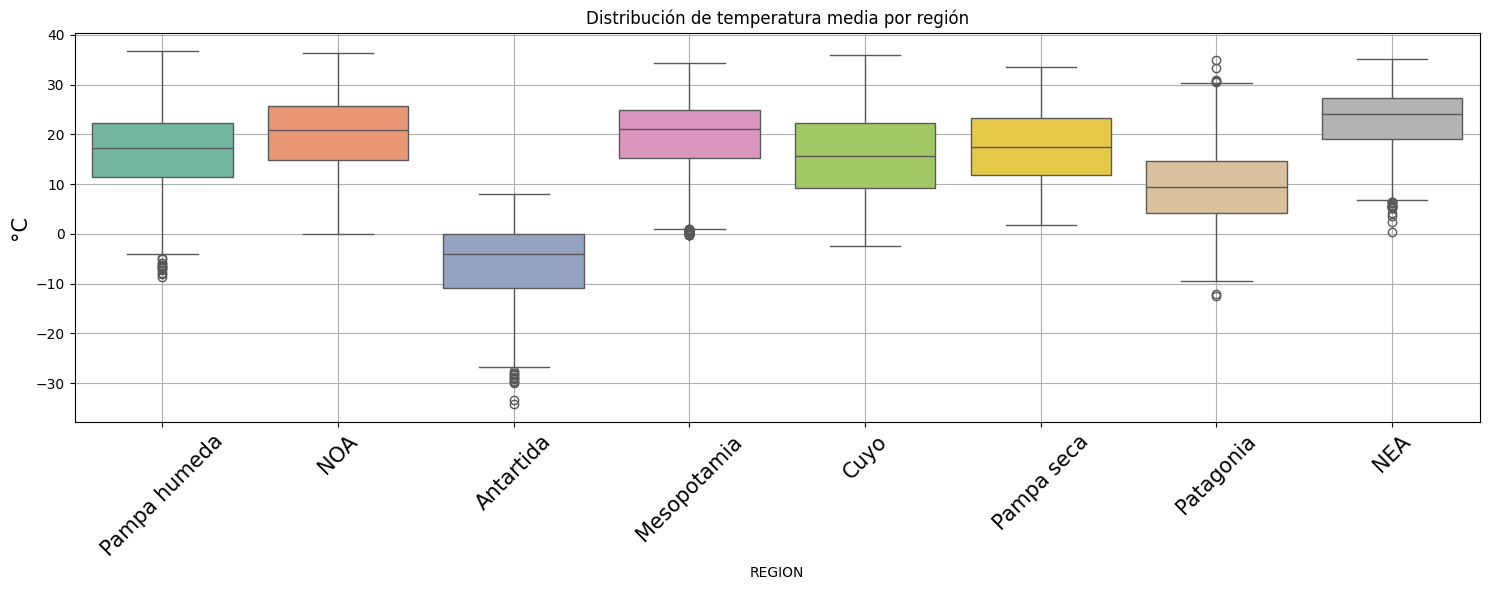

In [42]:
plt.figure(figsize=(15, 6))
sns.boxplot(x='REGION', y='TEMP_MEDIA', data=df_ly, palette='Set2')
plt.title('Distribuci√≥n de temperatura media por regi√≥n')
plt.ylabel('¬∞C', fontsize=15)
plt.xticks(rotation=45, fontsize=15)
plt.grid(True)
plt.tight_layout()
plt.show()


Distribuci√≥n de temperatura media por regi√≥n

El boxplot permite observar la dispersi√≥n de las temperaturas medias registradas a lo largo del a√±o para cada regi√≥n. Se destacan:

- Las regiones **NEA** y **Mesopotamia**, con valores m√°s altos y menor variabilidad.
- La **Ant√°rtida**, con temperaturas negativas y un rango m√°s comprimido.
- **NOA** y **Cuyo** presentan una mayor amplitud t√©rmica, lo cual refleja diferencias de altitud y continentalidad.
- Los outliers en algunas regiones corresponden a registros extremos propios de zonas particulares dentro de cada regi√≥n.

Esta visualizaci√≥n es √∫til para detectar asimetr√≠as, extremos t√©rmicos y superposici√≥n de distribuciones.


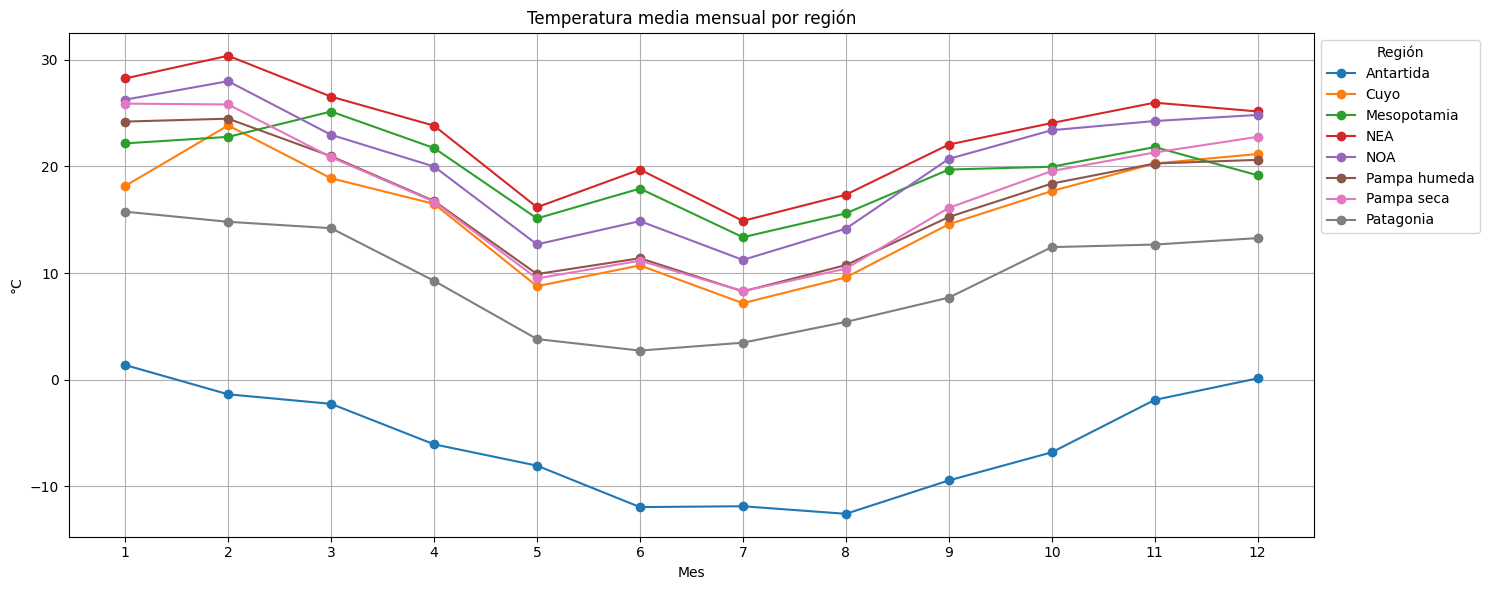

In [44]:
# Agrupar por mes y regi√≥n
mensual = df_ly.groupby(['REGION', 'mes'])['TEMP_MEDIA'].mean().reset_index()

# Graficar
plt.figure(figsize=(15, 6))
for region in sorted(df_ly['REGION'].dropna().unique()):
    datos = mensual[mensual['REGION'] == region]
    plt.plot(datos['mes'], datos['TEMP_MEDIA'], marker='o', label=region)

plt.title('Temperatura media mensual por regi√≥n')
plt.xlabel('Mes')
plt.ylabel('¬∞C')
plt.xticks(range(1, 13))
plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Regi√≥n')
plt.tight_layout()
plt.show()


Evoluci√≥n mensual de temperatura media por regi√≥n

Este gr√°fico muestra la temperatura media mensual de cada regi√≥n a lo largo del a√±o calendario. Se observa con claridad la estacionalidad en todas las regiones, con:

- Picos m√°ximos en los meses de verano (enero-febrero).
- M√≠nimos en los meses de invierno (julio-agosto).
- Diferencias claras entre regiones c√°lidas (NEA, Mesopotamia) y fr√≠as (Patagonia, Ant√°rtida).
- La regi√≥n **NEA** mantiene valores elevados incluso en invierno, debido a su baja latitud.

Este an√°lisis permite comparar el comportamiento t√©rmico mensual entre zonas del pa√≠s, destacando patrones clim√°ticos regionales.


### Dataset: Estad√≠sticas normales Datos abiertos 1991-2020

## 2.5 Reducci√≥n de la dimensionalidad

En esta etapa se explora la posibilidad de reducir el n√∫mero de variables utilizando t√©cnicas como PCA u otras, para simplificar el modelo sin perder informaci√≥n relevante.


### Dataset: registro_temperatura365d_smn

En este caso no se aplicaron t√©cnicas de reducci√≥n de dimensionalidad como PCA, ya que el dataset contiene un n√∫mero reducido de variables claramente interpretables y seleccionadas seg√∫n su relevancia para el an√°lisis (temperatura m√≠nima, m√°xima, media, regi√≥n, mes).

Dado que no se trabajar√° con modelos predictivos complejos ni con datasets multivariados, no se considera necesaria esta transformaci√≥n.


### Dataset: Estad√≠sticas normales Datos abiertos 1991-2020

In [36]:
# Copia y limpieza m√≠nima
df_30_2 = df_30_raw.copy()
df_30_2 = df_30_2.drop(columns=["Unnamed: 14"], errors="ignore")

# Convertir tipos
df_30_2['Estaci√≥n'] = df_30_2['Estaci√≥n'].astype('category')
df_30_2['Valor Medio de'] = df_30_2['Valor Medio de'].astype('category')

# Lista de columnas que NO quieres convertir
columnas_excluidas = ['Estaci√≥n', 'Valor Medio de']

# Iteramos sobre las columnas del DataFrame
for col in df_30_2.columns:
    if col not in columnas_excluidas:
        df_30_2[col] = pd.to_numeric(df_30_2[col], errors='coerce')

# 1. Selecci√≥n de columnas num√©ricas relevantes
cols_num = [
       'Ene', 'Feb', 'Mar', 'Abr', 'May',
       'Jun', 'Jul', 'Ago', 'Sep', 'Oct',
       'Nov', 'Dic'
]

# 2. Filtrar las columnas y eliminar NaNs
df_30_pca = df_30_2[cols_num].dropna().copy()

# 3. Escalar los datos (media 0, desviaci√≥n 1)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_30_pca)

# 4. Aplicar PCA
pca = PCA(n_components=2)
components = pca.fit_transform(scaled_data)

# 5. Resultado como DataFrame para graficar o analizar
df_components = pd.DataFrame(components, columns=['PC1', 'PC2'])#, 'PC3', 'PC4', 'PC5', 'PC6'])

# (Opcional) Informaci√≥n adicional: Driver, Team, etc.
df_components['Estaci√≥n'] = df_30_raw.loc[df_30_pca.index, 'Estaci√≥n'].values
df_components['Valor Medio de'] = df_30_raw.loc[df_30_pca.index, 'Valor Medio de'].values


In [37]:
df_components

PC1       PC2                Estaci√≥n  \
0   -1.675195 -0.074022  LA QUIACA OBSERVATORIO   
1   -0.580259  0.265807  LA QUIACA OBSERVATORIO   
2   -2.670268 -0.454068  LA QUIACA OBSERVATORIO   
3    1.971831 -0.664872  LA QUIACA OBSERVATORIO   
4   -2.063366  0.195123  LA QUIACA OBSERVATORIO   
..        ...       ...                     ...   
682 -2.174465  0.152735           BASE MARAMBIO   
683 -3.383756 -0.492844         BASE SAN MART√çN   
684 -3.004103 -0.367539         BASE SAN MART√çN   
685 -3.803938 -0.650955         BASE SAN MART√çN   
686 -2.125422  0.189506         BASE SAN MART√çN   

                              Valor Medio de  
0                           Temperatura (¬∞C)  
1                    Temperatura m√°xima (¬∞C)  
2                    Temperatura m√≠nima (¬∞C)  
3                       Humedad relativa (%)  
4    Velocidad del Viento (km/h) (2011-2020)  
..                                       ...  
682                Nubosidad total (octavos)  
683                         Temperatura (¬∞C)  
684                  Temperatura m√°xima (¬∞C)  
685                  Temperatura m√≠nima (¬∞C)  
686                Nubosidad total (octavos)  

[687 rows x 4 columns]

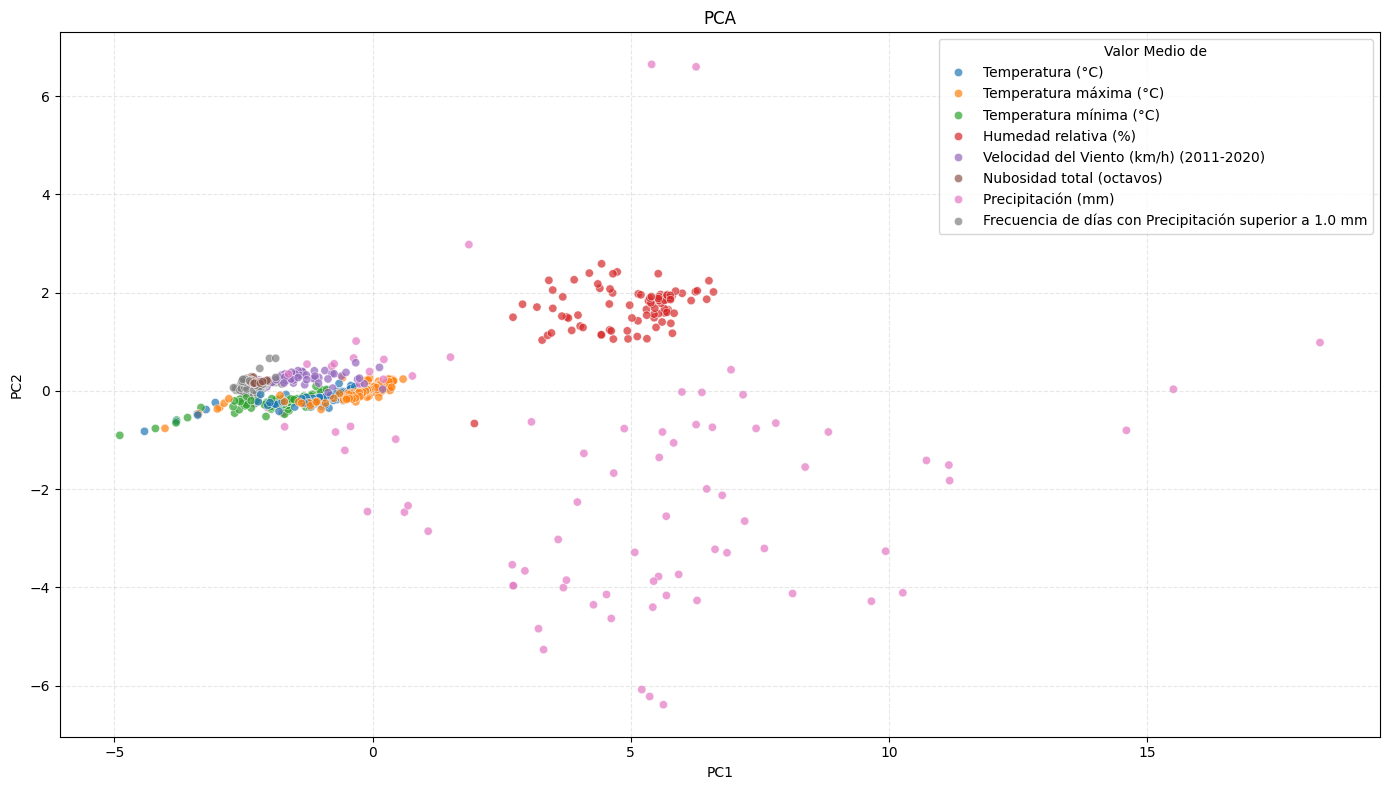

In [38]:
plt.figure(figsize=(14,8))
sns.scatterplot(data=df_components, x='PC1', y='PC2', hue='Valor Medio de', alpha=0.7)
plt.title('PCA')
plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()


In [39]:
# varianza explicada por cada componente
explained_var = pca.explained_variance_ratio_
explained_var

array([0.85444734, 0.12128281])

In [40]:
# varianza acumulada
cumulative_var = np.cumsum(explained_var)
cumulative_var

array([0.85444734, 0.97573014])

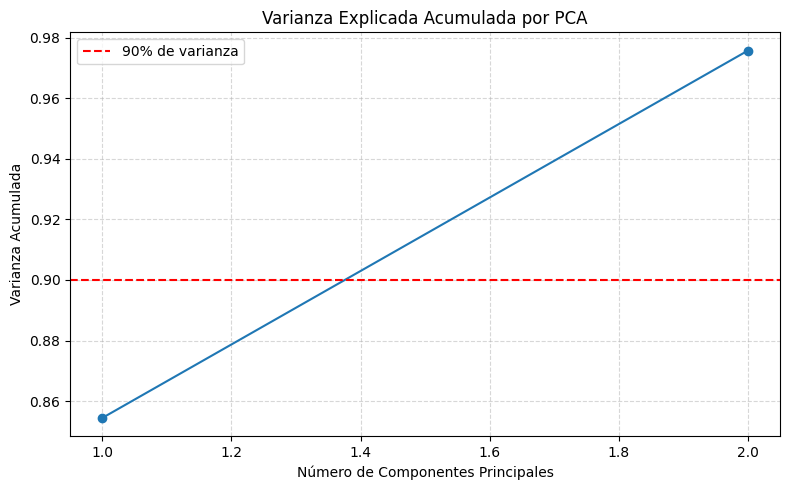

In [41]:
# Gr√°fico
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_var) + 1), cumulative_var, marker='o', linestyle='-')
plt.xlabel('N√∫mero de Componentes Principales')
plt.ylabel('Varianza Acumulada')
plt.title('Varianza Explicada Acumulada por PCA')
plt.axhline(y=0.9, color='red', linestyle='--', label='90% de varianza')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


In [42]:
# Pivotear para tener columnas por tipo de variable
df_pivot = df_30.pivot_table(
    index=['Estaci√≥n', 'Mes'],
    columns='Valor Medio de',
    values='Valor'
).reset_index()

# Filtrar filas que tengan ambas variables (sin NaN)
df_filtered = df_pivot.dropna(subset=['Humedad relativa (%)', 'Precipitaci√≥n (mm)'])


resultados = []

for estacion in df_filtered['Estaci√≥n'].unique():
    sub_df = df_filtered[df_filtered['Estaci√≥n'] == estacion]
    
    # Verificamos que haya m√°s de 2 puntos v√°lidos para correlaci√≥n
    if len(sub_df) >= 2:
        r, p = pearsonr(sub_df['Humedad relativa (%)'], sub_df['Precipitaci√≥n (mm)'])
        resultados.append({
            'Estaci√≥n': estacion,
            'Pearson_r': r,
            'p_valor': p,
            'Significativa': p <= 0.05
        })

# Mostrar resultados
resultados_df = pd.DataFrame(resultados)
print(resultados_df.sort_values(by='Pearson_r', ascending=False))


C:\Users\Juan\AppData\Local\Temp\ipykernel_5144\3815679465.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_pivot = df_30.pivot_table(


                   Estaci√≥n  Pearson_r   p_valor  Significativa
23              ESQUEL AERO   0.948235  0.000003           True
3            BARILOCHE AERO   0.944079  0.000004           True
35   LA QUIACA OBSERVATORIO   0.886832  0.000121           True
19          EL BOLS√ìN AERO*   0.862208  0.000309           True
11  COMODORO RIVADAVIA AERO   0.776473  0.002978           True
..                      ...        ...       ...            ...
73              SAN MIGUEL*  -0.666255  0.025194           True
28        GUALEGUAYCH√ö AERO  -0.686236  0.013727           True
55               PIG√ú√â AERO  -0.693073  0.012455           True
2         BAH√çA BLANCA AERO  -0.709532  0.009752           True
0           AEROPARQUE AERO  -0.724674  0.007675           True

[90 rows x 4 columns]


In [43]:
for estacion in df_filtered['Estaci√≥n'].unique():
    sub_df = df_filtered[df_filtered['Estaci√≥n'] == estacion]
    if len(sub_df) >= 2:
        r, p = pearsonr(sub_df['Humedad relativa (%)'], sub_df['Precipitaci√≥n (mm)'])
        conclusion = (
            "Rechazamos H‚ÇÄ: relaci√≥n significativa." if p <= 0.05
            else "No rechazamos H‚ÇÄ: sin relaci√≥n significativa."
        )
        print(f"{estacion} ‚Üí r={r:.2f}, p={p:.4f} ‚Üí {conclusion}")


AEROPARQUE AERO ‚Üí r=-0.72, p=0.0077 ‚Üí Rechazamos H‚ÇÄ: relaci√≥n significativa.
AZUL AERO* ‚Üí r=-0.52, p=0.0840 ‚Üí No rechazamos H‚ÇÄ: sin relaci√≥n significativa.
BAH√çA BLANCA AERO ‚Üí r=-0.71, p=0.0098 ‚Üí Rechazamos H‚ÇÄ: relaci√≥n significativa.
BARILOCHE AERO ‚Üí r=0.94, p=0.0000 ‚Üí Rechazamos H‚ÇÄ: relaci√≥n significativa.
BERNARDO DE IRIGOYEN AERO ‚Üí r=0.36, p=0.2436 ‚Üí No rechazamos H‚ÇÄ: sin relaci√≥n significativa.
BOL√çVAR AERO ‚Üí r=-0.50, p=0.0998 ‚Üí No rechazamos H‚ÇÄ: sin relaci√≥n significativa.
BUENOS AIRES OBSERVATORIO ‚Üí r=-0.60, p=0.0391 ‚Üí Rechazamos H‚ÇÄ: relaci√≥n significativa.
CATAMARCA AERO ‚Üí r=0.08, p=0.7990 ‚Üí No rechazamos H‚ÇÄ: sin relaci√≥n significativa.
CERES AERO ‚Üí r=-0.07, p=0.8194 ‚Üí No rechazamos H‚ÇÄ: sin relaci√≥n significativa.
CHAMICAL AERO ‚Üí r=0.03, p=0.9210 ‚Üí No rechazamos H‚ÇÄ: sin relaci√≥n significativa.
CHILECITO AERO ‚Üí r=0.09, p=0.8595 ‚Üí No rechazamos H‚ÇÄ: sin relaci√≥n significativa.
COMODORO RIVADAVIA AERO ‚Ü

#### üéØ Pregunta del test

¬øExiste una relaci√≥n mon√≥tona significativa entre la **humedad relativa mensual** y la **precipitaci√≥n mensual** en cada estaci√≥n meteorol√≥gica?

---

#### üß™ Hip√≥tesis estad√≠stica

Para cada estaci√≥n:

- **Hip√≥tesis nula (H‚ÇÄ):**  
  No existe una correlaci√≥n mon√≥tona significativa entre la humedad relativa (%) y la precipitaci√≥n (mm) mensual.  
  \[
  $\rho_s = 0$
  \]

- **Hip√≥tesis alternativa (H‚ÇÅ):**  
  Existe una correlaci√≥n mon√≥tona significativa entre la humedad relativa (%) y la precipitaci√≥n (mm) mensual.  
  \[
  $\rho_s$ $\neq 0$
  \]

---

#### ‚úÖ Criterio de decisi√≥n

- Si el **p-valor ‚â§ 0.05**, **rechazamos H‚ÇÄ**: hay evidencia suficiente para afirmar que existe una relaci√≥n significativa.
- Si el **p-valor > 0.05**, **no rechazamos H‚ÇÄ**: no hay evidencia suficiente de relaci√≥n.

---

#### üìä Prueba estad√≠stica utilizada

**Coeficiente de correlaci√≥n de Spearman (œÅ)**  
Este coeficiente mide la relaci√≥n mon√≥tona entre dos variables continuas, sin requerir que la relaci√≥n sea lineal ni que las variables sigan una distribuci√≥n normal.


In [ ]:


for estacion in df_filtered['Estaci√≥n'].unique():
    sub_df = df_filtered[df_filtered['Estaci√≥n'] == estacion]
    
    if len(sub_df) >= 2:
        r, p = spearmanr(sub_df['Humedad relativa (%)'], sub_df['Precipitaci√≥n (mm)'])
        conclusion = (
            "‚úÖ Rechazamos H‚ÇÄ: relaci√≥n significativa." if p <= 0.05
            else "üü° No rechazamos H‚ÇÄ: sin relaci√≥n significativa."
        )
        print(f"{estacion:<30} ‚Üí Spearman r = {r:.2f}, p = {p:.4f} ‚Üí {conclusion}")


AEROPARQUE AERO                ‚Üí Spearman r = -0.72, p = 0.0079 ‚Üí ‚úÖ Rechazamos H‚ÇÄ: relaci√≥n significativa.
AZUL AERO*                     ‚Üí Spearman r = -0.59, p = 0.0415 ‚Üí ‚úÖ Rechazamos H‚ÇÄ: relaci√≥n significativa.
BAH√çA BLANCA AERO              ‚Üí Spearman r = -0.62, p = 0.0332 ‚Üí ‚úÖ Rechazamos H‚ÇÄ: relaci√≥n significativa.
BARILOCHE AERO                 ‚Üí Spearman r = 0.98, p = 0.0000 ‚Üí ‚úÖ Rechazamos H‚ÇÄ: relaci√≥n significativa.
BERNARDO DE IRIGOYEN AERO      ‚Üí Spearman r = 0.06, p = 0.8629 ‚Üí üü° No rechazamos H‚ÇÄ: sin relaci√≥n significativa.
BOL√çVAR AERO                   ‚Üí Spearman r = -0.43, p = 0.1667 ‚Üí üü° No rechazamos H‚ÇÄ: sin relaci√≥n significativa.
BUENOS AIRES OBSERVATORIO      ‚Üí Spearman r = -0.58, p = 0.0479 ‚Üí ‚úÖ Rechazamos H‚ÇÄ: relaci√≥n significativa.
CATAMARCA AERO                 ‚Üí Spearman r = 0.15, p = 0.6331 ‚Üí üü° No rechazamos H‚ÇÄ: sin relaci√≥n significativa.
CERES AERO                     ‚Üí Spearman r = 0